<a href="https://colab.research.google.com/github/enok/flowpredict/blob/main/flowpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free Cash Flow Forecasting

<small><div style="text-align: right">The data will consist of quarterly reports spanning from 2012 to 2022.</div></small>
<small><div style="text-align: right">The forecasting will be from 2023 to 2025.</div></small>

### Mounting Google Drive (if is not running locally)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/drive/MyDrive/cursos/usp/mba/data-science/tcc/code/flowpredict'

## 1. Downloading and loading stock market data from the CVM website.

### Companies to be analised


| Company       | Ticker    | CVM Code  |
| :---          | :----     | ----:     |
| CPFL Energia  | CPFE3     | 18660     |
| Cemig         | CMIG4     | 2453      |
| Eletrobras    | ELET6     | 2437      |
| Enev          | ENEV3     | 21237     |
| Taesa         | TAEE11    | 20257     |

In [10]:
companies = {
    18660: {"name": "CPFL Energia", "ticker": "CPFE3"},
    2453:  {"name": "Cemig", "ticker": "CMIG4"},
    2437:  {"name": "Eletrobras", "ticker": "ELET6"},
    21237: {"name": "Enev", "ticker": "ENEV3"},
    20257: {"name": "Taesa", "ticker": "TAEE11"}
}

print(f'companies: {companies}\n')

companies: {18660: {'name': 'CPFL Energia', 'ticker': 'CPFE3'}, 2453: {'name': 'Cemig', 'ticker': 'CMIG4'}, 2437: {'name': 'Eletrobras', 'ticker': 'ELET6'}, 21237: {'name': 'Enev', 'ticker': 'ENEV3'}, 20257: {'name': 'Taesa', 'ticker': 'TAEE11'}}



### Accounts selected

Based on:<br>
Investiment Valuation Tools and Techniques for Determining the Value of Any Asset (Aswath Damodaran)<br>
    CHAPTER 14 - Free Cash Flow to Equity Discount Models<br><br>

*Free Cash Flows to Equity (FCFE) = <br>
	Net income - (Capital expenditures - Depreciation) <br>
	- (Change in noncash working capital) <br>
	+ (New debt issued - Debt repayments)*<br><br>


*Fluxo de Caixa Livre para os Acionistas (FCLPA) = <br>
Lucro Líquido<br>
 \- (Investimentos em Ativos Fixos - Depreciação)<br>
 \- (Variação no Capital de Giro, excluindo Caixa)<br>
 \+ (Novas Dívidas Emitidas - Pagamentos de Dívida)*<br><br>

*FCFE = <br>
  3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE)<br>
  \- (Δ 1.02.03 (Imobilizado) - 7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA))<br>
  \- (Δ 1.01 (Ativo Circulante) - Δ 1.01.01 (Caixa e Equivalentes de Caixa) -  Δ 2.01 (Passivo Circulante))<br>
  \+ (Δ 2.01.04(Emprestimos e Financiamentos Circulantes) + Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes))*<br><br>



**BPA**

| Code       | Description                                           |
| :---       | :----                                                 |
| 1.01       | Ativo Circulante                                      |
| 1.01.01    | Caixa e Equivalentes de Caixa                         |
| 1.02.03    | Imobilizado                                           |

<br>                                                                

**BPP**

| Code       | Description                                           |
| :---       | :----                                                 |
| 2.01       | Passivo Circulante                                    |
| 2.01.04    | Empréstimos e Financiamentos (Passivo Circulante)     |
| 2.02.01    | Empréstimos e Financiamentos (Passivo Nao Circulante) |

<br>                                                                
                                                                    
**DRE**

| Code       | Description                                           |
| :---       | :----                                                 |
| 3.11       | Lucro/Prejuízo Consolidado do Período                 |

<br>                                                                

**DVA**
                                                     
| Code       | Description                                           |
| :---       | :----                                                 |
| 7.04.01    | Depreciação, Amortização e Exaustão                   |


<small><div style="text-align: right">Source: <a>https://www.rad.cvm.gov.br/ENET/documentos/EspecificacaoArquivoXML_InformacoesTrimestrais.xlsx<a></div></small>

In [11]:
file_types = ['BPA', 'BPP', 'DRE', 'DVA']
print(f'file_types selected: {file_types}')

account_to_be_kept = ['1.01','1.01.01','1.02.03',
                    '2.01','2.01.04','2.02.01',
                    '3.11',
                    '7.04.01']
print(f'accounts selected: {account_to_be_kept}')

file_types selected: ['BPA', 'BPP', 'DRE', 'DVA']
accounts selected: ['1.01', '1.01.01', '1.02.03', '2.01', '2.01.04', '2.02.01', '3.11', '7.04.01']


### Interval of years

In [12]:
years = range(2012, 2023)

### Installing libs

In [13]:
%pip install requests beautifulsoup4
%pip install chardet
%pip install files
%pip install chardet


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Importing libs

In [14]:
import pandas as pd
import numpy as np
import re
import os
import requests
import zipfile
import chardet
from urllib.parse import urljoin
from bs4 import BeautifulSoup


### Setting Display

In [15]:
#pd.set_option('display.max_columns', 10)
pd.reset_option('display.max_columns')
pd.set_option('display.width', 200)
#pd.reset_option('display.width')

### Downloading balance sheets files

In [16]:
# Function to check if a file's encoding is UTF-8
def is_utf8(file_path):
    try:
        with open(file_path, 'rb') as file:
            raw_data = file.read()
            result = chardet.detect(raw_data)
            return result['encoding'] == 'utf-8'
    except Exception:
        return False

# URL of the website containing the ZIP files
base_url = "https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/"

# Create a directory to save the downloaded files
download_dir = "downloaded_files"
os.makedirs(download_dir, exist_ok=True)

# Define the years you want to download
years_to_download = set(str(year) for year in years)

# Send an HTTP GET request to the URL
response = requests.get(base_url)
response.raise_for_status()

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

# Find all links on the page
links = soup.find_all("a")

# Iterate through the links and download ZIP files for the specified years
for link in links:
    file_url = urljoin(base_url, link["href"])

    # Example: Assuming ZIP files are named like "itr_cia_aberta_YEAR.zip"
    if file_url.endswith(".zip"):
        zip_file_name = os.path.basename(file_url)

        # Extract the year from the ZIP file name
        year_part = zip_file_name.split("_")[-1].split(".")[0]

        # Check if the ZIP file is from a year within the specified range
        if year_part in years_to_download:
            # Check if the ZIP file already exists
            if not os.path.exists(os.path.join(download_dir, zip_file_name)):
                print(f"Downloading: {zip_file_name}")
                with open(os.path.join(download_dir, zip_file_name), "wb") as file:
                    file_response = requests.get(file_url)
                    file.write(file_response.content)
            else:
                print(f"File already exists: {zip_file_name}")

# Process the downloaded ZIP files (extract, remove "ind" files, and convert)
for zip_file_name in os.listdir(download_dir):
    if zip_file_name.endswith(".zip"):
        zip_file_path = os.path.join(download_dir, zip_file_name)
        zip_subdir = os.path.splitext(zip_file_name)[0]  # Use ZIP file name without extension as subdirectory name
        zip_subdir_path = os.path.join(download_dir, zip_subdir)

        # Check if the ZIP file has already been extracted
        if not os.path.exists(zip_subdir_path):
            print(f"Unzipping: {zip_file_name} -> {zip_subdir_path}")
            with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
                zip_ref.extractall(zip_subdir_path)

            # Remove files that are not in file_types
            for root, _, files in os.walk(zip_subdir_path):
                for file_name in files:
                    csv_file_type = os.path.splitext(file_name)[0][15:19].replace("_", "")
                    print(f"CSV type: {csv_file_type}")
                    if csv_file_type not in file_types:
                        file_path = os.path.join(root, file_name)
                        os.remove(file_path)
                        print(f"Removing: {file_path}, its not in the allowed list: {file_types}")

            # Remove files with "ind" in their names
            for root, _, files in os.walk(zip_subdir_path):
                for file_name in files:
                    if "ind" in file_name:
                        file_path = os.path.join(root, file_name)
                        os.remove(file_path)
                        print(f"Removing ind files (keeping con only): {file_path}")

            # Remove files with "itr_cia_aberta_20" in their names
            for root, _, files in os.walk(zip_subdir_path):
                for file_name in files:
                    if "itr_cia_aberta_20" in file_name:
                        file_path = os.path.join(root, file_name)
                        os.remove(file_path)
                        print(f"Removing itr_cia_aberta_20 file: {file_path}")

            # Convert CSV files from ISO-8859-1 to UTF-8 only if they are not already UTF-8
            for csv_file_name in os.listdir(zip_subdir_path):
                if csv_file_name.endswith(".csv"):
                    csv_file_path = os.path.join(zip_subdir_path, csv_file_name)
                    if not is_utf8(csv_file_path):
                        print(f"Converting encoding: {csv_file_path}")
                        with open(csv_file_path, 'r', encoding='ISO-8859-1') as source_file:
                            content = source_file.read()
                        with open(csv_file_path, 'w', encoding='utf-8') as target_file:
                            target_file.write(content)
                    else:
                        print(f"File already in UTF-8: {csv_file_path}")

print("Download, extraction, file removal, and encoding conversion completed.")


Downloading: itr_cia_aberta_2012.zip
File already exists: itr_cia_aberta_2013.zip
File already exists: itr_cia_aberta_2014.zip
File already exists: itr_cia_aberta_2015.zip
File already exists: itr_cia_aberta_2016.zip
File already exists: itr_cia_aberta_2017.zip
File already exists: itr_cia_aberta_2018.zip
File already exists: itr_cia_aberta_2019.zip
File already exists: itr_cia_aberta_2020.zip
File already exists: itr_cia_aberta_2021.zip
File already exists: itr_cia_aberta_2022.zip
Unzipping: itr_cia_aberta_2012.zip -> downloaded_files/itr_cia_aberta_2012
CSV type: 2012
Removing: downloaded_files/itr_cia_aberta_2012/itr_cia_aberta_2012.csv, its not in the allowed list: ['BPA', 'BPP', 'DRE', 'DVA']
CSV type: BPA
CSV type: BPA
CSV type: BPP
CSV type: BPP
CSV type: DFC
Removing: downloaded_files/itr_cia_aberta_2012/itr_cia_aberta_DFC_MD_con_2012.csv, its not in the allowed list: ['BPA', 'BPP', 'DRE', 'DVA']
CSV type: DFC
Removing: downloaded_files/itr_cia_aberta_2012/itr_cia_aberta_DFC_MD

### Creating the datasets

In [17]:
bpa_df = None
bpp_df = None
dre_df = None
dva_df = None

d_parser = lambda x: pd.datetime.strptime(format='%Y-%m-%d')

# Load files into Data Frames
for dir_name in os.listdir(download_dir):
    if not dir_name.endswith(".zip"):
        dir_path = os.path.join(download_dir, dir_name)

        for csv_file_name in os.listdir(dir_path):
            csv_file_path = os.path.join(dir_path, csv_file_name)
            print("\n-------------------------------------------------------")
            print(f"Reading csv file: {csv_file_path}")

            csv_file_type = os.path.splitext(csv_file_name)[0][15:19].replace("_", "")
            print(f"CSV type: {csv_file_type}")

            local_df = pd.read_csv(csv_file_path, sep=';')

            local_df['DT_REFER'] = pd.to_datetime(local_df['DT_REFER'], format='%Y-%m-%d')
            local_df['DT_FIM_EXERC'] = pd.to_datetime(local_df['DT_FIM_EXERC'], format='%Y-%m-%d')

            print(f"Dataframe size: {len(local_df)}")

            match csv_file_type:
                case 'BPA':
                    if bpa_df is None:
                        bpa_df = local_df
                    else:
                        bpa_df = pd.concat([bpa_df, local_df])
                    print(f"Dataframe size - after concat: {len(bpa_df)}")

                case 'BPP':
                    if bpp_df is None:
                        bpp_df = local_df
                    else:
                        bpp_df = pd.concat([bpp_df, local_df])
                    print(f"Dataframe size - after concat: {len(bpp_df)}")

                case 'DRE':
                    if dre_df is None:
                        dre_df = local_df
                    else:
                        dre_df = pd.concat([dre_df, local_df])
                    print(f"Dataframe size - after concat: {len(dre_df)}")

                case 'DVA':
                    if dva_df is None:
                        dva_df = local_df
                    else:
                        dva_df = pd.concat([dva_df, local_df])
                    print(f"Dataframe size - after concat: {len(dva_df)}")

print("\nbpa_df:")
print(bpa_df.head(2))

print("\nbpp_df:")
print(bpp_df.head(2))

print("\ndre_df:")
print(dre_df.head(2))

print("\ndva_df:")
print(dva_df.head(2))



-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2012/itr_cia_aberta_BPA_con_2012.csv
CSV type: BPA
Dataframe size: 132416
Dataframe size - after concat: 132416

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2012/itr_cia_aberta_BPP_con_2012.csv
CSV type: BPP
Dataframe size: 224976
Dataframe size - after concat: 224976

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2012/itr_cia_aberta_DRE_con_2012.csv
CSV type: DRE
Dataframe size: 119445
Dataframe size - after concat: 119445

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2012/itr_cia_aberta_DVA_con_2012.csv
CSV type: DVA
Dataframe size: 85694
Dataframe size - after concat: 85694

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2013/itr_cia_aberta

### Saving Dataframes

In [18]:
print("\n")
def saveToFile(dfName, df):
    fileName = dfName + '.csv'
    df = df.set_index('DT_REFER')
    print(f'\nsaving file: {fileName}')
    print(df.head(2))
    df.to_csv('processed_files/' + fileName, sep=';')

saveToFile('bpa_df', bpa_df)
saveToFile('bpp_df', bpp_df)
saveToFile('dre_df', dre_df)
saveToFile('dva_df', dva_df)




saving file: bpa_df.csv
                      CNPJ_CIA  VERSAO                             DENOM_CIA  CD_CVM                                   GRUPO_DFP MOEDA ESCALA_MOEDA ORDEM_EXERC DT_FIM_EXERC CD_CONTA     DS_CONTA  \
DT_REFER                                                                                                                                                                                             
2012-03-31  00.001.180/0001-26       2  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Ativo  REAL          MIL   PENÚLTIMO   2011-12-31        1  Ativo Total   
2012-03-31  00.001.180/0001-26       2  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Ativo  REAL          MIL      ÚLTIMO   2012-03-31        1  Ativo Total   

               VL_CONTA ST_CONTA_FIXA  
DT_REFER                               
2012-03-31  163142432.0             S  
2012-03-31  164768886.0             S  

saving file: bpp_df

## 2. Data analising

### Loading Dataframes

In [19]:
print("\n")
def readCsv(dfName):
    fileName = dfName + '.csv'
    print(f'\nreading file: {fileName}')
    df_read = pd.read_csv('processed_files/' + fileName, sep=';')
    print(df_read.head(2))
    return df_read

bpa_df = readCsv('bpa_df')
bpp_df = readCsv('bpp_df')
dre_df = readCsv('dre_df')
dva_df = readCsv('dva_df')




reading file: bpa_df.csv
     DT_REFER            CNPJ_CIA  VERSAO                             DENOM_CIA  CD_CVM                                   GRUPO_DFP MOEDA ESCALA_MOEDA ORDEM_EXERC DT_FIM_EXERC CD_CONTA     DS_CONTA  \
0  2012-03-31  00.001.180/0001-26       2  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Ativo  REAL          MIL   PENÚLTIMO   2011-12-31        1  Ativo Total   
1  2012-03-31  00.001.180/0001-26       2  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Ativo  REAL          MIL      ÚLTIMO   2012-03-31        1  Ativo Total   

      VL_CONTA ST_CONTA_FIXA  
0  163142432.0             S  
1  164768886.0             S  

reading file: bpp_df.csv
     DT_REFER            CNPJ_CIA  VERSAO                             DENOM_CIA  CD_CVM                                     GRUPO_DFP MOEDA ESCALA_MOEDA ORDEM_EXERC DT_FIM_EXERC CD_CONTA  \
0  2012-03-31  00.001.180/0001-26       2  CENTRAIS ELET BR

### Describing data structures

In [20]:
def print_df(df_name, df):
    print(f'\n\n{df_name}: {len(df):,} records')
    print('-------------------------------------------------------------------')
    print('\t\t\t TYPES')
    print(df.dtypes)

    print('\t\t\t NULL VALUES')
    print('CNPJ_CIA: ' + str(df['CNPJ_CIA'].isnull().sum().sum()))
    print('DT_REFER: ' + str(df['DT_REFER'].isnull().sum().sum()))
    print('VERSAO: ' + str(df['VERSAO'].isnull().sum().sum()))
    print('DENOM_CIA: ' + str(df['DENOM_CIA'].isnull().sum().sum()))
    print('CD_CVM: ' + str(df['CD_CVM'].isnull().sum().sum()))
    print('GRUPO_DFP: ' + str(df['GRUPO_DFP'].isnull().sum().sum()))
    print('MOEDA: ' + str(df['MOEDA'].isnull().sum().sum()))
    print('ESCALA_MOEDA: ' + str(df['ESCALA_MOEDA'].isnull().sum().sum()))
    print('ORDEM_EXERC: ' + str(df['ORDEM_EXERC'].isnull().sum().sum()))
    print('DT_FIM_EXERC: ' + str(df['DT_FIM_EXERC'].isnull().sum().sum()))
    print('CD_CONTA: ' + str(df['CD_CONTA'].isnull().sum().sum()))
    print('DS_CONTA: ' + str(df['DS_CONTA'].isnull().sum().sum()))
    print('VL_CONTA: ' + str(df['VL_CONTA'].isnull().sum().sum()))
    print('ST_CONTA_FIXA: ' + str(df['ST_CONTA_FIXA'].isnull().sum().sum()))

    print('\t\t\t COUNT UNIQUE VALUES')
    print('CNPJ_CIA: ' + str(len(df['CNPJ_CIA'].unique())))
    print('DT_REFER: ' + str(len(df['DT_REFER'].unique())))
    print('VERSAO: ' + str(len(df['VERSAO'].unique())))
    print('DENOM_CIA: ' + str(len(df['DENOM_CIA'].unique())))
    print('CD_CVM: ' + str(len(df['CD_CVM'].unique())))
    print('GRUPO_DFP: ' + str(len(df['GRUPO_DFP'].unique())))
    print('MOEDA: ' + str(len(df['MOEDA'].unique())))
    print('ESCALA_MOEDA: ' + str(len(df['ESCALA_MOEDA'].unique())))
    print('ORDEM_EXERC: ' + str(len(df['ORDEM_EXERC'].unique())))
    print('DT_FIM_EXERC: ' + str(len(df['DT_FIM_EXERC'].unique())))
    print('CD_CONTA: ' + str(len(df['CD_CONTA'].unique())))
    print('DS_CONTA: ' + str(len(df['DS_CONTA'].unique())))
    print('VL_CONTA: ' + str(len(df['VL_CONTA'].unique())))
    print('ST_CONTA_FIXA: ' + str(len(df['ST_CONTA_FIXA'].unique())))

    print('\t\t\t UNIQUE VALUES')
    print('CNPJ_CIA: ' + str(len(df['CNPJ_CIA'].unique())))
    print('DT_REFER: ' + str(len(df['DT_REFER'].unique())))
    print('VERSAO: ' + str(df['VERSAO'].unique()))
    print('DENOM_CIA: ' + str(len(df['DENOM_CIA'].unique())))
    print('CD_CVM: ' + str(len(df['CD_CVM'].unique())))
    print('GRUPO_DFP: ' + str(df['GRUPO_DFP'].unique()))
    print('MOEDA: ' + str(df['MOEDA'].unique()))
    print('ESCALA_MOEDA: ' + str(df['ESCALA_MOEDA'].unique()))
    print('ORDEM_EXERC: ' + str(df['ORDEM_EXERC'].unique()))
    print('DT_FIM_EXERC: ' + str(len(df['DT_FIM_EXERC'].unique())))
    print('CD_CONTA: ' + str(len(df['CD_CONTA'].unique())))
    print('DS_CONTA: ' + str(len(df['DS_CONTA'].unique())))
    print('VL_CONTA: ' + str(len(df['VL_CONTA'].unique())))
    print('ST_CONTA_FIXA: ' + str(df['ST_CONTA_FIXA'].unique()))


print_df('bpa_df', bpa_df)
print_df('bpp_df', bpp_df)
print_df('dre_df', dre_df)
print_df('dva_df', dva_df)




bpa_df: 1,530,122 records
-------------------------------------------------------------------
			 TYPES
DT_REFER          object
CNPJ_CIA          object
VERSAO             int64
DENOM_CIA         object
CD_CVM             int64
GRUPO_DFP         object
MOEDA             object
ESCALA_MOEDA      object
ORDEM_EXERC       object
DT_FIM_EXERC      object
CD_CONTA          object
DS_CONTA          object
VL_CONTA         float64
ST_CONTA_FIXA     object
dtype: object
			 NULL VALUES
CNPJ_CIA: 0
DT_REFER: 0
VERSAO: 0
DENOM_CIA: 0
CD_CVM: 0
GRUPO_DFP: 0
MOEDA: 0
ESCALA_MOEDA: 0
ORDEM_EXERC: 0
DT_FIM_EXERC: 0
CD_CONTA: 0
DS_CONTA: 0
VL_CONTA: 0
ST_CONTA_FIXA: 0
			 COUNT UNIQUE VALUES
CNPJ_CIA: 634
DT_REFER: 63
VERSAO: 6
DENOM_CIA: 676
CD_CVM: 636
GRUPO_DFP: 1
MOEDA: 1
ESCALA_MOEDA: 2
ORDEM_EXERC: 2
DT_FIM_EXERC: 78
CD_CONTA: 414
DS_CONTA: 5310
VL_CONTA: 240540
ST_CONTA_FIXA: 2
			 UNIQUE VALUES
CNPJ_CIA: 634
DT_REFER: 63
VERSAO: [2 1 3 4 5 6]
DENOM_CIA: 676
CD_CVM: 636
GRUPO_DFP: ['DF Cons

## 3. Data cleansing

### Cleaning up

In [21]:
# calculate value according to field ESCALA_MOELA
def set_vl_conta(df_name, df):
    print(f'setting vl_conta based on escala_moeda: {df_name}')
    df['VL_CONTA'] = np.where(df['ESCALA_MOEDA'] == 'MIL', df['VL_CONTA'] * 1000, df['VL_CONTA'])
    return df

def remove_non_mandatory_columns(df_name, df):
    print(f'removing non mandatory columns from: {df_name}')
    existing_cols = df.columns.intersection(['CNPJ_CIA', 'VERSAO', 'DENOM_CIA', 'MOEDA', 'ESCALA_MOEDA', 'DT_INI_EXERC', 'COLUNA_DF', 'ST_CONTA_FIXA'])
    return df.drop(columns=existing_cols, axis=1)

def remove_non_used_accounts(df_name, df):
    print(f'removing non used accounts for: {df_name}')
    print(f'accounts selected: {account_to_be_kept}')
    return df[df['CD_CONTA'].isin(account_to_be_kept)]


print("\n")
bpa_df = set_vl_conta('bpa_df', bpa_df)
bpp_df = set_vl_conta('bpp_df', bpp_df)
dre_df = set_vl_conta('dre_df', dre_df)
dva_df = set_vl_conta('dva_df', dva_df)

print("\n")
bpa_df = remove_non_mandatory_columns('bpa_df', bpa_df)
bpp_df = remove_non_mandatory_columns('bpp_df', bpp_df)
dre_df = remove_non_mandatory_columns('dre_df', dre_df)
dva_df = remove_non_mandatory_columns('dva_df', dva_df)

print("\n")
bpa_df = remove_non_used_accounts('bpa_df', bpa_df)
bpp_df = remove_non_used_accounts('bpp_df', bpp_df)
dre_df = remove_non_used_accounts('dre_df', dre_df)
dva_df = remove_non_used_accounts('dva_df', dva_df)




setting vl_conta based on escala_moeda: bpa_df
setting vl_conta based on escala_moeda: bpp_df
setting vl_conta based on escala_moeda: dre_df
setting vl_conta based on escala_moeda: dva_df


removing non mandatory columns from: bpa_df
removing non mandatory columns from: bpp_df
removing non mandatory columns from: dre_df
removing non mandatory columns from: dva_df


removing non used accounts for: bpa_df
accounts selected: ['1.01', '1.01.01', '1.02.03', '2.01', '2.01.04', '2.02.01', '3.11', '7.04.01']
removing non used accounts for: bpp_df
accounts selected: ['1.01', '1.01.01', '1.02.03', '2.01', '2.01.04', '2.02.01', '3.11', '7.04.01']
removing non used accounts for: dre_df
accounts selected: ['1.01', '1.01.01', '1.02.03', '2.01', '2.01.04', '2.02.01', '3.11', '7.04.01']
removing non used accounts for: dva_df
accounts selected: ['1.01', '1.01.01', '1.02.03', '2.01', '2.01.04', '2.02.01', '3.11', '7.04.01']


## 4. Data transformation

### Merge dataframes into one

In [22]:
df = pd.concat([bpa_df, bpp_df, dre_df, dva_df])

print(df.dtypes)
print("\n")
print(df)
print("\n")
df.head()

DT_REFER         object
CD_CVM            int64
GRUPO_DFP        object
ORDEM_EXERC      object
DT_FIM_EXERC     object
CD_CONTA         object
DS_CONTA         object
VL_CONTA        float64
dtype: object


          DT_REFER  CD_CVM                                          GRUPO_DFP ORDEM_EXERC DT_FIM_EXERC CD_CONTA                             DS_CONTA      VL_CONTA
2       2012-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2011-12-31     1.01                     Ativo Circulante  3.666267e+10
3       2012-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO   2012-03-31     1.01                     Ativo Circulante  3.665730e+10
4       2012-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2011-12-31  1.01.01        Caixa e Equivalentes de Caixa  7.994425e+09
5       2012-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO   2012-03-31  1.01.01        Caixa e Equivalentes 

,DT_REFER,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
2,2012-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2011-12-31,1.01,Ativo Circulante,3.666267e+10
3,2012-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,2012-03-31,1.01,Ativo Circulante,3.665730e+10
4,2012-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2011-12-31,1.01.01,Caixa e Equivalentes de Caixa,7.994425e+09
5,2012-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,2012-03-31,1.01.01,Caixa e Equivalentes de Caixa,8.232203e+09
142,2012-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2011-12-31,1.02.03,Imobilizado,5.321486e+10


### Saving merged Dataframes

In [23]:
saveToFile('df', df)



saving file: df.csv
            CD_CVM                                   GRUPO_DFP ORDEM_EXERC DT_FIM_EXERC CD_CONTA          DS_CONTA      VL_CONTA
DT_REFER                                                                                                                        
2012-03-31    2437  DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2011-12-31     1.01  Ativo Circulante  3.666267e+10
2012-03-31    2437  DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO   2012-03-31     1.01  Ativo Circulante  3.665730e+10


### Loading merged Dataframes

In [24]:
df = readCsv('df')

print(df.dtypes)
print("\n")
print(df)
print("\n")
df.head()


reading file: df.csv
     DT_REFER  CD_CVM                                   GRUPO_DFP ORDEM_EXERC DT_FIM_EXERC CD_CONTA          DS_CONTA      VL_CONTA
0  2012-03-31    2437  DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2011-12-31     1.01  Ativo Circulante  3.666267e+10
1  2012-03-31    2437  DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO   2012-03-31     1.01  Ativo Circulante  3.665730e+10
DT_REFER         object
CD_CVM            int64
GRUPO_DFP        object
ORDEM_EXERC      object
DT_FIM_EXERC     object
CD_CONTA         object
DS_CONTA         object
VL_CONTA        float64
dtype: object


          DT_REFER  CD_CVM                                          GRUPO_DFP ORDEM_EXERC DT_FIM_EXERC CD_CONTA                             DS_CONTA      VL_CONTA
0       2012-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2011-12-31     1.01                     Ativo Circulante  3.666267e+10
1       2012-03-31    2437         DF Consolidad

,DT_REFER,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
0,2012-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2011-12-31,1.01,Ativo Circulante,3.666267e+10
1,2012-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,2012-03-31,1.01,Ativo Circulante,3.665730e+10
2,2012-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2011-12-31,1.01.01,Caixa e Equivalentes de Caixa,7.994425e+09
3,2012-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,2012-03-31,1.01.01,Caixa e Equivalentes de Caixa,8.232203e+09
4,2012-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2011-12-31,1.02.03,Imobilizado,5.321486e+10


### Selecting companies

In [25]:
print(f'selecting companies : {companies}')
companies_df = df[df['CD_CVM'].isin(companies)]

print(companies_df.dtypes)
print("\n")
print(companies_df)
print("\n")
companies_df.head(2)

selecting companies : {18660: {'name': 'CPFL Energia', 'ticker': 'CPFE3'}, 2453: {'name': 'Cemig', 'ticker': 'CMIG4'}, 2437: {'name': 'Eletrobras', 'ticker': 'ELET6'}, 21237: {'name': 'Enev', 'ticker': 'ENEV3'}, 20257: {'name': 'Taesa', 'ticker': 'TAEE11'}}
DT_REFER         object
CD_CVM            int64
GRUPO_DFP        object
ORDEM_EXERC      object
DT_FIM_EXERC     object
CD_CONTA         object
DS_CONTA         object
VL_CONTA        float64
dtype: object


          DT_REFER  CD_CVM                                          GRUPO_DFP ORDEM_EXERC DT_FIM_EXERC CD_CONTA                             DS_CONTA      VL_CONTA
0       2012-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2011-12-31     1.01                     Ativo Circulante  3.666267e+10
1       2012-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO   2012-03-31     1.01                     Ativo Circulante  3.665730e+10
2       2012-03-31    2437         DF Consoli

,DT_REFER,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
0,2012-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2011-12-31,1.01,Ativo Circulante,3.666267e+10
1,2012-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,2012-03-31,1.01,Ativo Circulante,3.665730e+10


### Saving companies Dataframe

In [26]:
saveToFile('../companies_df', companies_df)



saving file: ../companies_df.csv
            CD_CVM                                   GRUPO_DFP ORDEM_EXERC DT_FIM_EXERC CD_CONTA          DS_CONTA      VL_CONTA
DT_REFER                                                                                                                        
2012-03-31    2437  DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2011-12-31     1.01  Ativo Circulante  3.666267e+10
2012-03-31    2437  DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO   2012-03-31     1.01  Ativo Circulante  3.665730e+10


### Loading companies DataFrame

In [27]:
df = readCsv('../companies_df')

print(df.dtypes)
print("\n")
print(df)
print("\n")
df.head()


reading file: ../companies_df.csv
     DT_REFER  CD_CVM                                   GRUPO_DFP ORDEM_EXERC DT_FIM_EXERC CD_CONTA          DS_CONTA      VL_CONTA
0  2012-03-31    2437  DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2011-12-31     1.01  Ativo Circulante  3.666267e+10
1  2012-03-31    2437  DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO   2012-03-31     1.01  Ativo Circulante  3.665730e+10
DT_REFER         object
CD_CVM            int64
GRUPO_DFP        object
ORDEM_EXERC      object
DT_FIM_EXERC     object
CD_CONTA         object
DS_CONTA         object
VL_CONTA        float64
dtype: object


        DT_REFER  CD_CVM                                          GRUPO_DFP ORDEM_EXERC DT_FIM_EXERC CD_CONTA                             DS_CONTA      VL_CONTA
0     2012-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO   2011-12-31     1.01                     Ativo Circulante  3.666267e+10
1     2012-03-31    2437         DF Con

,DT_REFER,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
0,2012-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2011-12-31,1.01,Ativo Circulante,3.666267e+10
1,2012-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,2012-03-31,1.01,Ativo Circulante,3.665730e+10
2,2012-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2011-12-31,1.01.01,Caixa e Equivalentes de Caixa,7.994425e+09
3,2012-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,2012-03-31,1.01.01,Caixa e Equivalentes de Caixa,8.232203e+09
4,2012-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,2011-12-31,1.02.03,Imobilizado,5.321486e+10


### Basic functions for cleaning up

In [28]:
# Reorder the columns to move 'ORDEM_EXERC' to the last position
cols = list(df.columns)
cols.remove('ORDEM_EXERC')
cols.insert(-1, 'ORDEM_EXERC')
df = df[cols]

# Reorder the columns to move 'CD_CONTA' to the 2nd position
cols = list(df.columns)
cols.remove('CD_CONTA')
cols.insert(2, 'CD_CONTA')
df = df[cols]

# DT_REFER asdatetime
df['DT_REFER'] = pd.to_datetime(df['DT_REFER'], format='%Y-%m-%d')


def createPenultimo_DT_FIM_EXERC(df, position):

    columnName = 'DT_FIM_EXERC'

    # The field DT_FIM_EXERC for BPA and BPP is 3 months in the past, for the others (DRE, DVA) this value is past 12 months
    newColumnNameBP = columnName + '_PENULTIMO' + '_BP'
    newColumnName = columnName + '_PENULTIMO'
    bpList = ['DF Consolidado - Balanço Patrimonial Ativo', 'DF Consolidado - Balanço Patrimonial Passivo']

    df[newColumnNameBP] = np.where(
        (df['ORDEM_EXERC'] == 'PENÚLTIMO') & df['GRUPO_DFP'].isin(bpList),
        df[columnName],
        None)
    df[newColumnName] = np.where(
        (df['ORDEM_EXERC'] == 'PENÚLTIMO') & ~(df['GRUPO_DFP'].isin(bpList)),
        df[columnName],
        None)

    # remove this same values from column
    df[columnName] = np.where(
        df['ORDEM_EXERC'] != 'PENÚLTIMO',
        df[columnName],
        None)

    df[newColumnNameBP] = pd.to_datetime(df[newColumnNameBP], format='%Y-%m-%d')
    df[newColumnName] = pd.to_datetime(df[newColumnName], format='%Y-%m-%d')
    df[columnName] = pd.to_datetime(df[columnName], format='%Y-%m-%d')

    # Reorder the columns to move to correct position
    cols = list(df.columns)

        # BP
    cols.remove(newColumnNameBP)
    cols.insert(position, newColumnNameBP)
    df = df[cols]

        # not BP
    cols.remove(newColumnName)
    cols.insert(position+1, newColumnName)
    df = df[cols]

    return df

def createPenultimo_VL_CONTA(df, position):

    columnName = 'VL_CONTA'

    # The field DT_FIM_EXERC for BPA and BPP is 3 months in the past, for the others (DRE, DVA) this value is past 12 months
    newColumnName = columnName + '_PENULTIMO'

    df[newColumnName] = np.where(
        (df['ORDEM_EXERC'] == 'PENÚLTIMO'),
        df[columnName],
        None)

    # remove this same values from column
    df[columnName] = np.where(
        df['ORDEM_EXERC'] != 'PENÚLTIMO',
        df[columnName],
        None)

    df[newColumnName] = df[newColumnName].astype(float)
    df[columnName] = df[columnName].astype(float)

    # Reorder the columns to move to correct position
    cols = list(df.columns)

    cols.remove(newColumnName)
    cols.insert(position, newColumnName)
    df = df[cols]

    return df


### Create column 'DT_FIM_EXERC_PENULTIMO'

In [29]:
df = createPenultimo_DT_FIM_EXERC(df, 4)

print(df.dtypes)
print("\n")
df.head()


DT_REFER                     datetime64[ns]
CD_CVM                                int64
CD_CONTA                             object
GRUPO_DFP                            object
DT_FIM_EXERC_PENULTIMO_BP    datetime64[ns]
DT_FIM_EXERC_PENULTIMO       datetime64[ns]
DT_FIM_EXERC                 datetime64[ns]
DS_CONTA                             object
ORDEM_EXERC                          object
VL_CONTA                            float64
dtype: object




,DT_REFER,CD_CVM,CD_CONTA,GRUPO_DFP,DT_FIM_EXERC_PENULTIMO_BP,DT_FIM_EXERC_PENULTIMO,DT_FIM_EXERC,DS_CONTA,ORDEM_EXERC,VL_CONTA
0,2012-03-31,2437,1.01,DF Consolidado - Balanço Patrimonial Ativo,2011-12-31,NaT,NaT,Ativo Circulante,PENÚLTIMO,3.666267e+10
1,2012-03-31,2437,1.01,DF Consolidado - Balanço Patrimonial Ativo,NaT,NaT,2012-03-31,Ativo Circulante,ÚLTIMO,3.665730e+10
2,2012-03-31,2437,1.01.01,DF Consolidado - Balanço Patrimonial Ativo,2011-12-31,NaT,NaT,Caixa e Equivalentes de Caixa,PENÚLTIMO,7.994425e+09
3,2012-03-31,2437,1.01.01,DF Consolidado - Balanço Patrimonial Ativo,NaT,NaT,2012-03-31,Caixa e Equivalentes de Caixa,ÚLTIMO,8.232203e+09
4,2012-03-31,2437,1.02.03,DF Consolidado - Balanço Patrimonial Ativo,2011-12-31,NaT,NaT,Imobilizado,PENÚLTIMO,5.321486e+10


#### Create column 'VL_CONTA_PENULTIMO'

In [30]:
df = createPenultimo_VL_CONTA(df, 8)

print(df.dtypes)
print("\n")
df.head()

DT_REFER                     datetime64[ns]
CD_CVM                                int64
CD_CONTA                             object
GRUPO_DFP                            object
DT_FIM_EXERC_PENULTIMO_BP    datetime64[ns]
DT_FIM_EXERC_PENULTIMO       datetime64[ns]
DT_FIM_EXERC                 datetime64[ns]
DS_CONTA                             object
VL_CONTA_PENULTIMO                  float64
ORDEM_EXERC                          object
VL_CONTA                            float64
dtype: object




,DT_REFER,CD_CVM,CD_CONTA,GRUPO_DFP,DT_FIM_EXERC_PENULTIMO_BP,DT_FIM_EXERC_PENULTIMO,DT_FIM_EXERC,DS_CONTA,VL_CONTA_PENULTIMO,ORDEM_EXERC,VL_CONTA
0,2012-03-31,2437,1.01,DF Consolidado - Balanço Patrimonial Ativo,2011-12-31,NaT,NaT,Ativo Circulante,3.666267e+10,PENÚLTIMO,NaN
1,2012-03-31,2437,1.01,DF Consolidado - Balanço Patrimonial Ativo,NaT,NaT,2012-03-31,Ativo Circulante,NaN,ÚLTIMO,3.665730e+10
2,2012-03-31,2437,1.01.01,DF Consolidado - Balanço Patrimonial Ativo,2011-12-31,NaT,NaT,Caixa e Equivalentes de Caixa,7.994425e+09,PENÚLTIMO,NaN
3,2012-03-31,2437,1.01.01,DF Consolidado - Balanço Patrimonial Ativo,NaT,NaT,2012-03-31,Caixa e Equivalentes de Caixa,NaN,ÚLTIMO,8.232203e+09
4,2012-03-31,2437,1.02.03,DF Consolidado - Balanço Patrimonial Ativo,2011-12-31,NaT,NaT,Imobilizado,5.321486e+10,PENÚLTIMO,NaN


#### Remove disposable columns

In [31]:
cols = df.columns.intersection(['GRUPO_DFP', 'DS_CONTA', 'ORDEM_EXERC'])
df = df.drop(columns=cols, axis=1)

print(df.dtypes)
print("\n")
df.head()

DT_REFER                     datetime64[ns]
CD_CVM                                int64
CD_CONTA                             object
DT_FIM_EXERC_PENULTIMO_BP    datetime64[ns]
DT_FIM_EXERC_PENULTIMO       datetime64[ns]
DT_FIM_EXERC                 datetime64[ns]
VL_CONTA_PENULTIMO                  float64
VL_CONTA                            float64
dtype: object




,DT_REFER,CD_CVM,CD_CONTA,DT_FIM_EXERC_PENULTIMO_BP,DT_FIM_EXERC_PENULTIMO,DT_FIM_EXERC,VL_CONTA_PENULTIMO,VL_CONTA
0,2012-03-31,2437,1.01,2011-12-31,NaT,NaT,3.666267e+10,NaN
1,2012-03-31,2437,1.01,NaT,NaT,2012-03-31,NaN,3.665730e+10
2,2012-03-31,2437,1.01.01,2011-12-31,NaT,NaT,7.994425e+09,NaN
3,2012-03-31,2437,1.01.01,NaT,NaT,2012-03-31,NaN,8.232203e+09
4,2012-03-31,2437,1.02.03,2011-12-31,NaT,NaT,5.321486e+10,NaN


#### Group by 'DT_REFER', 'CD_CVM', and 'CD_CONTA' and aggregate the values

In [32]:
agg_funcs = {
    'DT_FIM_EXERC_PENULTIMO_BP': 'first',
    'DT_FIM_EXERC_PENULTIMO': 'first',
    'DT_FIM_EXERC': 'first',
    'VL_CONTA_PENULTIMO': 'last',
    'VL_CONTA': 'last'
}

df = df.groupby(['DT_REFER', 'CD_CVM', 'CD_CONTA']).agg(agg_funcs).reset_index()

# Reorder the columns as needed
df = df[['DT_REFER', 'CD_CVM', 'CD_CONTA', 'DT_FIM_EXERC_PENULTIMO_BP', 'DT_FIM_EXERC_PENULTIMO', 'DT_FIM_EXERC', 'VL_CONTA_PENULTIMO', 'VL_CONTA']]

# View the final DataFrame
print(df.dtypes)
print("\n")
df.head()

DT_REFER                     datetime64[ns]
CD_CVM                                int64
CD_CONTA                             object
DT_FIM_EXERC_PENULTIMO_BP    datetime64[ns]
DT_FIM_EXERC_PENULTIMO       datetime64[ns]
DT_FIM_EXERC                 datetime64[ns]
VL_CONTA_PENULTIMO                  float64
VL_CONTA                            float64
dtype: object




,DT_REFER,CD_CVM,CD_CONTA,DT_FIM_EXERC_PENULTIMO_BP,DT_FIM_EXERC_PENULTIMO,DT_FIM_EXERC,VL_CONTA_PENULTIMO,VL_CONTA
0,2012-03-31,2437,1.01,2011-12-31,NaT,2012-03-31,3.666267e+10,3.665730e+10
1,2012-03-31,2437,1.01.01,2011-12-31,NaT,2012-03-31,7.994425e+09,8.232203e+09
2,2012-03-31,2437,1.02.03,2011-12-31,NaT,2012-03-31,5.321486e+10,5.438703e+10
3,2012-03-31,2437,2.01,2011-12-31,NaT,2012-03-31,2.612481e+10,2.643410e+10
4,2012-03-31,2437,2.01.04,2011-12-31,NaT,2012-03-31,4.887560e+09,5.466635e+09


#### Saving df before transposing

In [33]:
saveToFile('../companies_before_transposing_df', df)



saving file: ../companies_before_transposing_df.csv
            CD_CVM CD_CONTA DT_FIM_EXERC_PENULTIMO_BP DT_FIM_EXERC_PENULTIMO DT_FIM_EXERC  VL_CONTA_PENULTIMO      VL_CONTA
DT_REFER                                                                                                                   
2012-03-31    2437     1.01                2011-12-31                    NaT   2012-03-31        3.666267e+10  3.665730e+10
2012-03-31    2437  1.01.01                2011-12-31                    NaT   2012-03-31        7.994425e+09  8.232203e+09


#### Loading df before transposing

In [34]:
df = readCsv('../companies_before_transposing_df')

print(df.dtypes)
print("\n")
print(df)
print("\n")
df.head()



reading file: ../companies_before_transposing_df.csv
     DT_REFER  CD_CVM CD_CONTA DT_FIM_EXERC_PENULTIMO_BP DT_FIM_EXERC_PENULTIMO DT_FIM_EXERC  VL_CONTA_PENULTIMO      VL_CONTA
0  2012-03-31    2437     1.01                2011-12-31                    NaN   2012-03-31        3.666267e+10  3.665730e+10
1  2012-03-31    2437  1.01.01                2011-12-31                    NaN   2012-03-31        7.994425e+09  8.232203e+09
DT_REFER                      object
CD_CVM                         int64
CD_CONTA                      object
DT_FIM_EXERC_PENULTIMO_BP     object
DT_FIM_EXERC_PENULTIMO        object
DT_FIM_EXERC                  object
VL_CONTA_PENULTIMO           float64
VL_CONTA                     float64
dtype: object


        DT_REFER  CD_CVM CD_CONTA DT_FIM_EXERC_PENULTIMO_BP DT_FIM_EXERC_PENULTIMO DT_FIM_EXERC  VL_CONTA_PENULTIMO      VL_CONTA
0     2012-03-31    2437     1.01                2011-12-31                    NaN   2012-03-31        3.666267e+10  3.6657

,DT_REFER,CD_CVM,CD_CONTA,DT_FIM_EXERC_PENULTIMO_BP,DT_FIM_EXERC_PENULTIMO,DT_FIM_EXERC,VL_CONTA_PENULTIMO,VL_CONTA
0,2012-03-31,2437,1.01,2011-12-31,NaN,2012-03-31,3.666267e+10,3.665730e+10
1,2012-03-31,2437,1.01.01,2011-12-31,NaN,2012-03-31,7.994425e+09,8.232203e+09
2,2012-03-31,2437,1.02.03,2011-12-31,NaN,2012-03-31,5.321486e+10,5.438703e+10
3,2012-03-31,2437,2.01,2011-12-31,NaN,2012-03-31,2.612481e+10,2.643410e+10
4,2012-03-31,2437,2.01.04,2011-12-31,NaN,2012-03-31,4.887560e+09,5.466635e+09


#### Transforming rows into column to have one register by date, company and account type

In [35]:
# Filling NaN values with empty strings
df.fillna('', inplace=True)

# Creating the pivot table
df_pivot = df.pivot_table(
    index=['DT_REFER', 'CD_CVM', 'DT_FIM_EXERC_PENULTIMO_BP', 'DT_FIM_EXERC_PENULTIMO', 'DT_FIM_EXERC'],
    columns='CD_CONTA',
    values=['VL_CONTA_PENULTIMO', 'VL_CONTA'],
    aggfunc='first'
).reset_index()

# Flattening the multi-level columns
df_pivot.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_pivot.columns.values]

# Reordering the columns
ordered_columns = (
    ['DT_REFER', 'CD_CVM', 'DT_FIM_EXERC_PENULTIMO_BP', 'DT_FIM_EXERC_PENULTIMO', 'DT_FIM_EXERC'] +
    [col for col in df_pivot.columns if col.startswith('VL_CONTA_PENULTIMO_')] +
    [col for col in df_pivot.columns if col.startswith('VL_CONTA_') and not col.startswith('VL_CONTA_PENULTIMO_')]
)

df_pivot = df_pivot[ordered_columns]

print("\n-------------------------------------")
print(df_pivot)
print("-------------------------------------\n")

def custom_agg(series):
    # If the dtype is datetime, check for non-NaT values
    if series.dtype == 'datetime64[ns]':
        non_nat_values = [val for val in series if not pd.isna(val)]
        return non_nat_values[0] if non_nat_values else pd.NaT
    else:
        # If it's numeric, check for non-NaN values
        if pd.api.types.is_numeric_dtype(series):
            non_nan_values = [val for val in series if not pd.isna(val)]
            return non_nan_values[0] if non_nan_values else np.nan
        # Else check for non-empty strings
        else:
            non_empty_values = [val for val in series if val != '']
            return non_empty_values[0] if non_empty_values else ''

# Create an aggregation dictionary excluding columns you're grouping by
grouping_columns = ['DT_REFER', 'CD_CVM', 'DT_FIM_EXERC']
agg_dict = {col: custom_agg for col in ordered_columns if col not in grouping_columns}

# Group by 'DT_REFER', 'CD_CVM', and 'DT_FIM_EXERC', then aggregate
grouped_df = df_pivot.groupby(grouping_columns).agg(agg_dict).reset_index()

cols = list(grouped_df.columns)
cols.remove('DT_FIM_EXERC')
cols.insert(4, 'DT_FIM_EXERC')
grouped_df = grouped_df[cols]

print("\n-------------------------------------")
print(grouped_df)
print("-------------------------------------\n")

saveToFile('../df_pivot', grouped_df)



-------------------------------------
       DT_REFER  CD_CVM DT_FIM_EXERC_PENULTIMO_BP DT_FIM_EXERC_PENULTIMO DT_FIM_EXERC  VL_CONTA_PENULTIMO_1.01  VL_CONTA_PENULTIMO_1.01.01  VL_CONTA_PENULTIMO_1.02.03  VL_CONTA_PENULTIMO_2.01  \
0    2012-03-31    2437                                       2011-03-31   2012-03-31                      NaN                         NaN                         NaN                      NaN   
1    2012-03-31    2437                2011-12-31                          2012-03-31             3.666267e+10                7.994425e+09                5.321486e+10             2.612481e+10   
2    2012-03-31    2453                                       2011-03-31   2012-03-31                      NaN                         NaN                         NaN                      NaN   
3    2012-03-31    2453                2011-12-31                          2012-03-31             8.531649e+09                2.862490e+09                8.661791e+09             1.

#### Reading the cleaned up and grouped dataframe

In [36]:
final_df = readCsv('../df_pivot')

print(final_df.dtypes)
print("\n")
print(final_df)
print("\n")
final_df.head()


reading file: ../df_pivot.csv
     DT_REFER  CD_CVM DT_FIM_EXERC_PENULTIMO_BP DT_FIM_EXERC_PENULTIMO DT_FIM_EXERC  VL_CONTA_PENULTIMO_1.01  VL_CONTA_PENULTIMO_1.01.01  VL_CONTA_PENULTIMO_1.02.03  VL_CONTA_PENULTIMO_2.01  \
0  2012-03-31    2437                2011-12-31             2011-03-31   2012-03-31             3.666267e+10                7.994425e+09                5.321486e+10             2.612481e+10   
1  2012-03-31    2453                2011-12-31             2011-03-31   2012-03-31             8.531649e+09                2.862490e+09                8.661791e+09             1.216935e+10   

   VL_CONTA_PENULTIMO_2.01.04  ...  VL_CONTA_PENULTIMO_3.11  VL_CONTA_PENULTIMO_7.04.01  VL_CONTA_1.01  VL_CONTA_1.01.01  VL_CONTA_1.02.03  VL_CONTA_2.01  VL_CONTA_2.01.04  VL_CONTA_2.02.01  \
0                4.887560e+09  ...             1.288848e+09                -425125000.0   3.665730e+10      8.232203e+09      5.438703e+10   2.643410e+10      5.466635e+09      4.043558e+10   
1  

,DT_REFER,CD_CVM,DT_FIM_EXERC_PENULTIMO_BP,DT_FIM_EXERC_PENULTIMO,DT_FIM_EXERC,VL_CONTA_PENULTIMO_1.01,VL_CONTA_PENULTIMO_1.01.01,VL_CONTA_PENULTIMO_1.02.03,VL_CONTA_PENULTIMO_2.01,VL_CONTA_PENULTIMO_2.01.04,...,VL_CONTA_PENULTIMO_3.11,VL_CONTA_PENULTIMO_7.04.01,VL_CONTA_1.01,VL_CONTA_1.01.01,VL_CONTA_1.02.03,VL_CONTA_2.01,VL_CONTA_2.01.04,VL_CONTA_2.02.01,VL_CONTA_3.11,VL_CONTA_7.04.01
0,2012-03-31,2437,2011-12-31,2011-03-31,2012-03-31,3.666267e+10,7.994425e+09,5.321486e+10,2.612481e+10,4.887560e+09,...,1.288848e+09,-425125000.0,3.665730e+10,8.232203e+09,5.438703e+10,2.643410e+10,5.466635e+09,4.043558e+10,1.272468e+09,-443522000.0
1,2012-03-31,2453,2011-12-31,2011-03-31,2012-03-31,8.531649e+09,2.862490e+09,8.661791e+09,1.216935e+10,7.821060e+09,...,5.261510e+08,-232797000.0,8.462174e+09,2.234744e+09,8.692198e+09,9.399513e+09,4.788680e+09,1.063251e+10,6.313880e+08,-237551000.0
2,2012-03-31,18660,2011-12-31,2011-03-31,2012-03-31,5.363055e+09,2.699837e+09,8.292076e+09,4.499437e+09,1.653053e+09,...,4.658750e+08,-151723000.0,5.529380e+09,2.707338e+09,8.497946e+09,4.703766e+09,1.940757e+09,1.192139e+10,4.231980e+08,-179693000.0
3,2012-03-31,20257,2011-12-31,2011-03-31,2012-03-31,1.556749e+09,4.954060e+08,1.394000e+07,1.647891e+09,1.307947e+09,...,7.283400e+07,-373000.0,1.754579e+09,6.910900e+08,1.429200e+07,1.703948e+09,1.378329e+09,1.989889e+09,9.582200e+07,-406000.0
4,2012-03-31,21237,2011-12-31,2011-03-31,2012-03-31,1.708592e+09,1.442415e+09,5.393809e+09,1.632130e+09,1.061150e+09,...,-5.259300e+07,-1964000.0,1.711946e+09,1.308186e+09,5.988480e+09,2.274991e+09,1.681223e+09,4.807610e+09,-7.776000e+07,-2920000.0


#### Free Cash Flow formula

*FCFE = <br>
  3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE)<br>
  \- (Δ 1.02.03 (Imobilizado) - 7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA))<br>
  \- (Δ 1.01 (Ativo Circulante) - Δ 1.01.01 (Caixa e Equivalentes de Caixa) -  Δ 2.01 (Passivo Circulante))<br>
  \+ (Δ 2.01.04(Emprestimos e Financiamentos Circulantes) + Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes))*<br><br>


*3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE) = <br>
  LUCRO_LIQUIDO_PERIODO*<br>


*Δ 1.02.03 (Imobilizado) = <br>
  IMOBILIZADO_NO_PERIODO_ANTERIOR - IMOBILIZADO_NO_PERIODO*<br>


*7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA) = <br>
  DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA*<br>


*Δ 1.01 (Ativo Circulante) = <br>
  ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR - ATIVO_CIRCULANTE_NO_PERIODO*<br>


*Δ 1.01.01 (Caixa e Equivalentes de Caixa) = <br>
  CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR - CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO*<br>


*Δ 2.01 (Passivo Circulante) = <br>
  PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR - PASSIVO_CIRCULANTE_NO_PERIODO*<br>


*Δ 2.01.04(Emprestimos e Financiamentos Circulantes) = <br>
  EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR - EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO*<br>


*Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes) = <br>
  EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR - EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO*<br>

In [37]:
####################################################################
# Lucro/Prejuizo Consolidado do Periodo do DRE (3.11)
####################################################################
final_df['LUCRO_LIQUIDO_PERIODO'] = final_df['VL_CONTA_3.11']


####################################################################
# Δ Imobilizado (1.02.03)
####################################################################
final_df['IMOBILIZADO_NO_PERIODO_ANTERIOR'] = final_df['VL_CONTA_PENULTIMO_1.02.03']
final_df['IMOBILIZADO_NO_PERIODO'] = final_df['VL_CONTA_1.02.03']
final_df['IMOBILIZADO'] = final_df['IMOBILIZADO_NO_PERIODO_ANTERIOR'] - final_df['IMOBILIZADO_NO_PERIODO']


####################################################################
# Depreciacao, Amortizacao e Exaustao da DVA (7.04.01)
####################################################################
final_df['DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA'] = final_df['VL_CONTA_7.04.01']


####################################################################
# Δ Ativo Circulante (1.01)
####################################################################
final_df['ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] = final_df['VL_CONTA_PENULTIMO_1.01']
final_df['ATIVO_CIRCULANTE_NO_PERIODO'] = final_df['VL_CONTA_1.01']
final_df['ATIVO_CIRCULANTE'] = final_df['ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] - final_df['ATIVO_CIRCULANTE_NO_PERIODO']


####################################################################
# Δ Caixa e Equivalentes de Caixa (1.01.01)
####################################################################
final_df['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR'] = final_df['VL_CONTA_PENULTIMO_1.01.01']
final_df['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO'] = final_df['VL_CONTA_1.01.01']
final_df['CAIXA_E_EQUIVALENTES_DE_CAIXA'] = final_df['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR'] - final_df['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO']


####################################################################
# Δ Passivo Circulante (2.01)
####################################################################
final_df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR'] = final_df['VL_CONTA_PENULTIMO_2.01']
final_df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO'] = final_df['VL_CONTA_2.01']
final_df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES'] = final_df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR'] - final_df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO']


####################################################################
# Δ Emprestimos e Financiamentos Circulantes (2.01.04)
####################################################################
final_df['PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] = final_df['VL_CONTA_PENULTIMO_2.01.04']
final_df['PASSIVO_CIRCULANTE_NO_PERIODO'] = final_df['VL_CONTA_2.01.04']
final_df['PASSIVO_CIRCULANTE'] = final_df['PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] - final_df['PASSIVO_CIRCULANTE_NO_PERIODO']


####################################################################
# Δ Emprestimos e Financiamentos Nao Circulantes (2.02.01)
####################################################################
final_df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR'] = final_df['VL_CONTA_PENULTIMO_2.02.01']
final_df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO'] = final_df['VL_CONTA_2.02.01']
final_df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES'] = final_df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR'] - final_df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO']


# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#
# Fluxo de Caixa Livre para os Acionistas (Free Cash Flows to Equity) - FCFE
#
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
final_df['FCFE'] = \
    final_df['LUCRO_LIQUIDO_PERIODO'] \
    - ( final_df['IMOBILIZADO'] - final_df['DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA'] ) \
    - ( final_df['ATIVO_CIRCULANTE'] - final_df['CAIXA_E_EQUIVALENTES_DE_CAIXA'] - final_df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES'] ) \
    + ( final_df['PASSIVO_CIRCULANTE'] + final_df['CAIXA_E_EQUIVALENTES_DE_CAIXA'] - final_df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES'] )

saveToFile('../final_df', final_df)

print(final_df)


saving file: ../final_df.csv
            CD_CVM DT_FIM_EXERC_PENULTIMO_BP DT_FIM_EXERC_PENULTIMO DT_FIM_EXERC  VL_CONTA_PENULTIMO_1.01  VL_CONTA_PENULTIMO_1.01.01  VL_CONTA_PENULTIMO_1.02.03  VL_CONTA_PENULTIMO_2.01  \
DT_REFER                                                                                                                                                                                     
2012-03-31    2437                2011-12-31             2011-03-31   2012-03-31             3.666267e+10                7.994425e+09                5.321486e+10             2.612481e+10   
2012-03-31    2453                2011-12-31             2011-03-31   2012-03-31             8.531649e+09                2.862490e+09                8.661791e+09             1.216935e+10   

            VL_CONTA_PENULTIMO_2.01.04  VL_CONTA_PENULTIMO_2.02.01  ...  EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR  EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO  \
DT_REFER           

#### Loading the data already strutured and cleaned

In [38]:
# ARIMA
%pip install statsmodels
# matplotlib (para visualizações)
%pip install matplotlib
# pmdarima (para a seleção automática do modelo ARIMA)
%pip install pmdarima
# statsmodels
%pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [39]:
import pandas as pd

data = pd.read_csv('final_df.csv', sep=';')

data['DT_REFER'] = pd.to_datetime(data['DT_REFER'], format='%Y-%m-%d')
data['DT_FIM_EXERC_PENULTIMO_BP'] = pd.to_datetime(data['DT_FIM_EXERC_PENULTIMO_BP'], format='%Y-%m-%d')
data['DT_FIM_EXERC_PENULTIMO'] = pd.to_datetime(data['DT_FIM_EXERC_PENULTIMO'], format='%Y-%m-%d')
data['DT_FIM_EXERC'] = pd.to_datetime(data['DT_FIM_EXERC'], format='%Y-%m-%d')
data = data.set_index('DT_REFER')


#### Exploratory Data Analysis (EDA)

##### Time Series Visualization

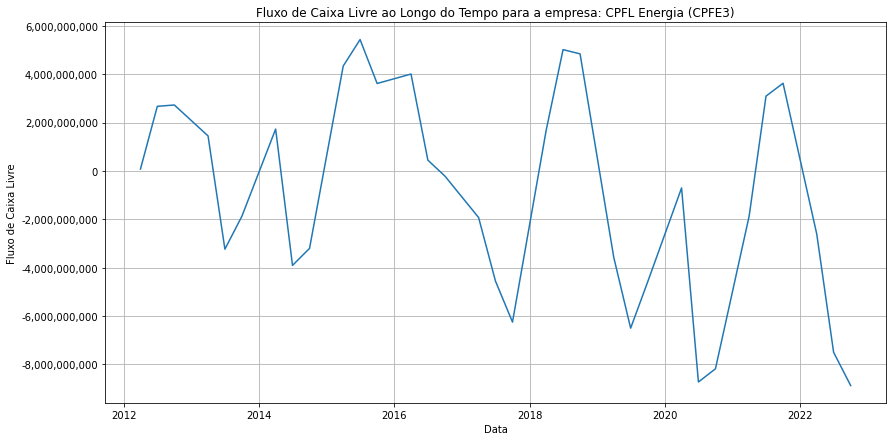

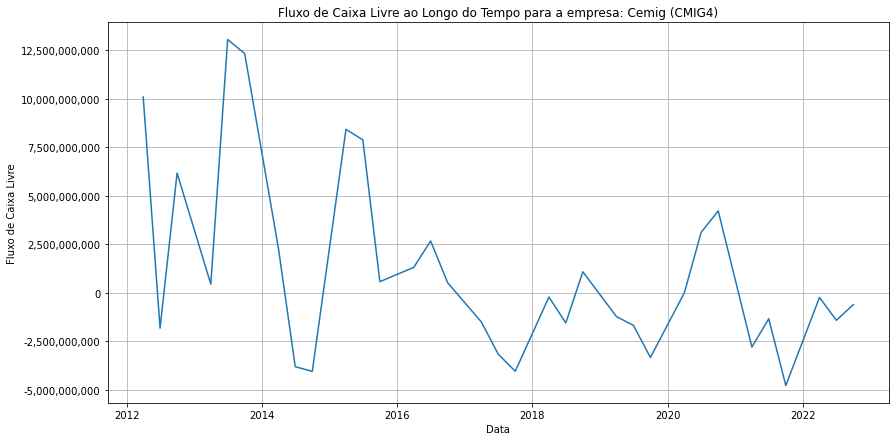

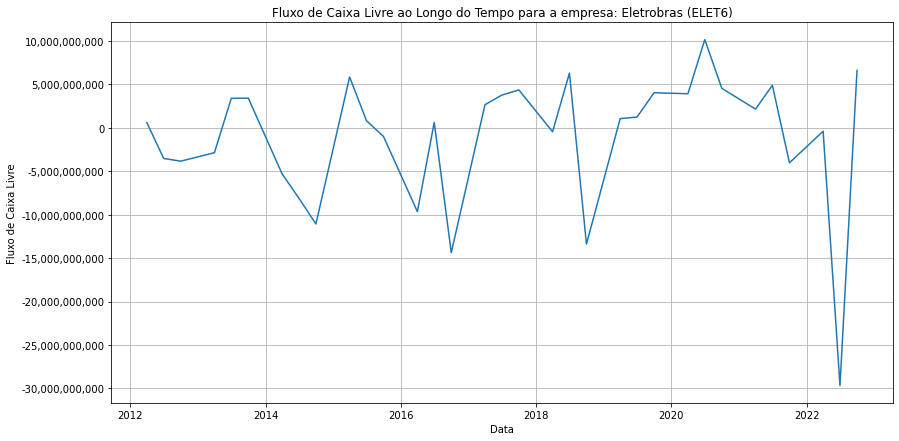

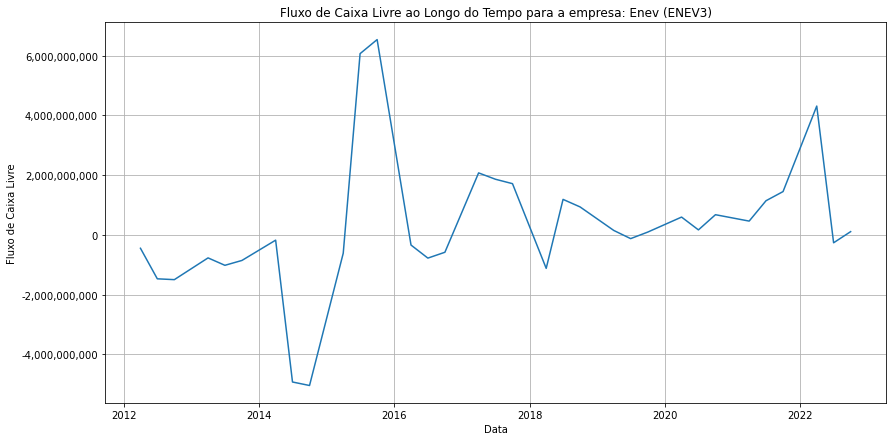

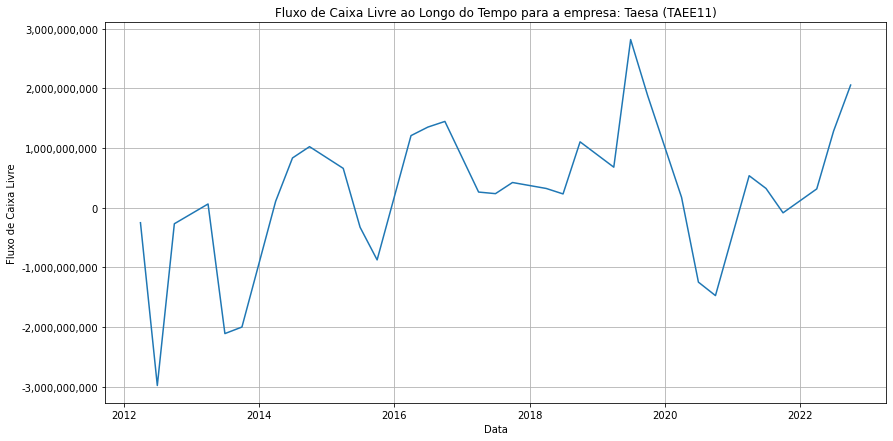

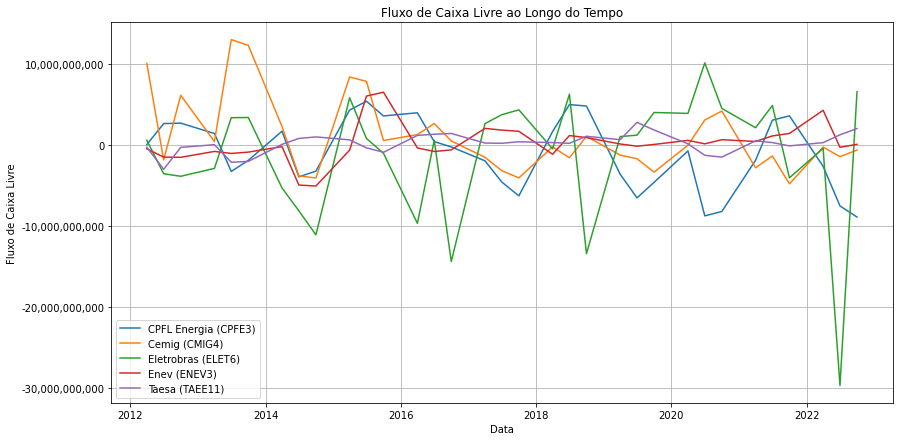

In [40]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def thousands_formatter(x, pos):
    return f'{int(x):,}'

formatter = FuncFormatter(thousands_formatter)

def print_serie(df, company_code):
    company = companies[company_code]
    plt.figure(figsize=(14,7))
    plt.plot(df.index, df['FCFE'])
    plt.title(f"Fluxo de Caixa Livre ao Longo do Tempo para a empresa: {company['name']} ({company['ticker']})")
    plt.xlabel('Data')
    plt.ylabel('Fluxo de Caixa Livre')
    plt.grid(True)
    plt.ticklabel_format(style='plain', axis='y')
    ax = plt.gca()  # get current axis
    ax.yaxis.set_major_formatter(formatter)  # set the formatter for y axis
    plt.show()

for company_code in companies:
    company_data = data[data['CD_CVM'] == company_code]
    print_serie(company_data, company_code)


def plot_combined_series(data, companies):
    plt.figure(figsize=(14,7))

    for company_code in companies:
        company_data = data[data['CD_CVM'] == company_code]
        company = companies[company_code]
        plt.plot(company_data.index, company_data['FCFE'], label=f"{company['name']} ({company['ticker']})")

    plt.title('Fluxo de Caixa Livre ao Longo do Tempo')
    plt.xlabel('Data')
    plt.ylabel('Fluxo de Caixa Livre')
    plt.legend(loc='best')
    plt.ticklabel_format(style='plain', axis='y')
    ax = plt.gca()  # get current axis
    ax.yaxis.set_major_formatter(formatter)  # set the formatter for y axis
    plt.grid(True)
    plt.show()

plot_combined_series(data, companies)

##### Time Series Decomposition

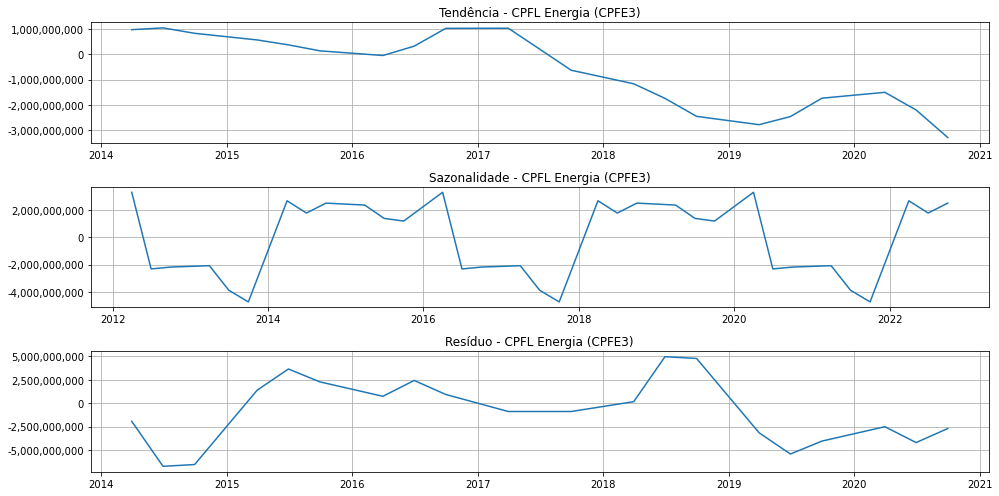

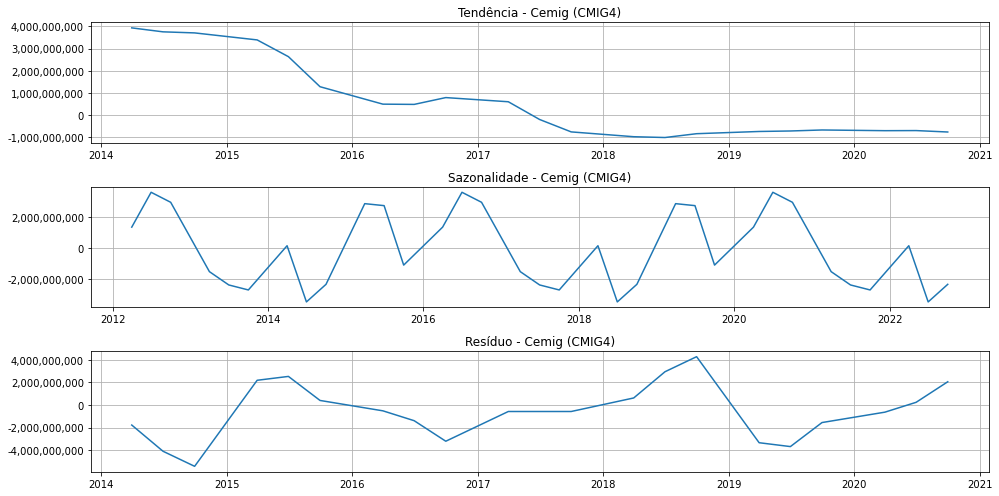

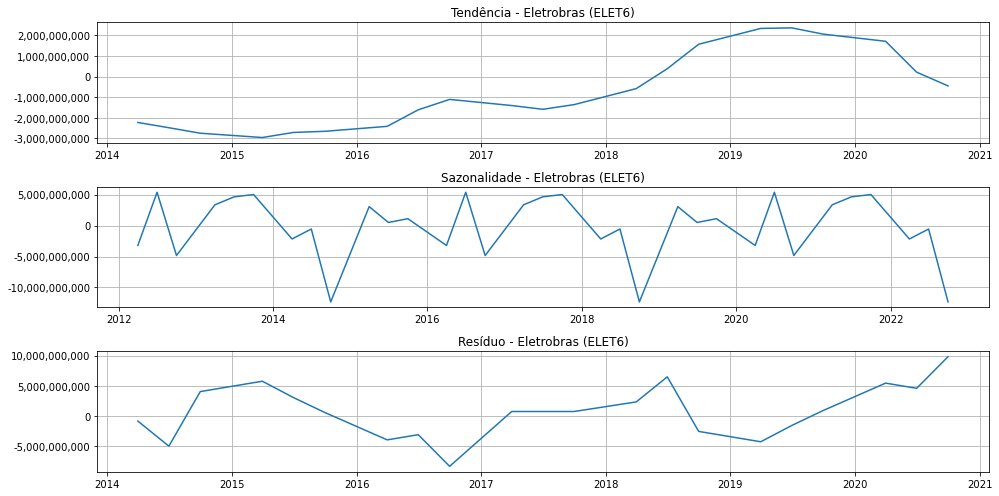

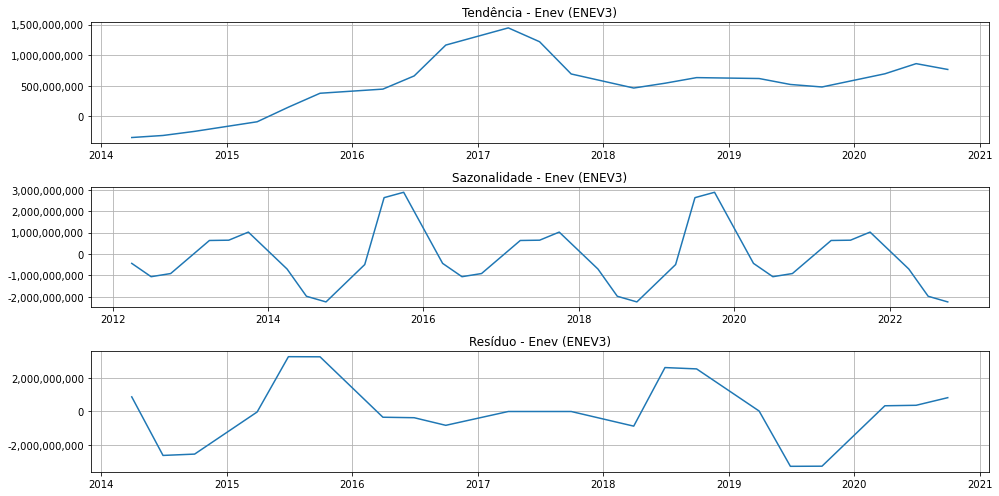

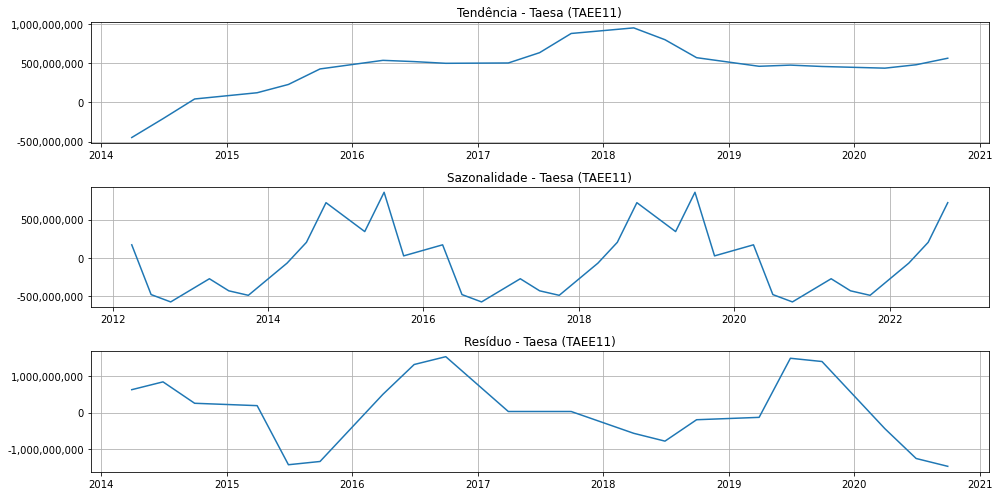

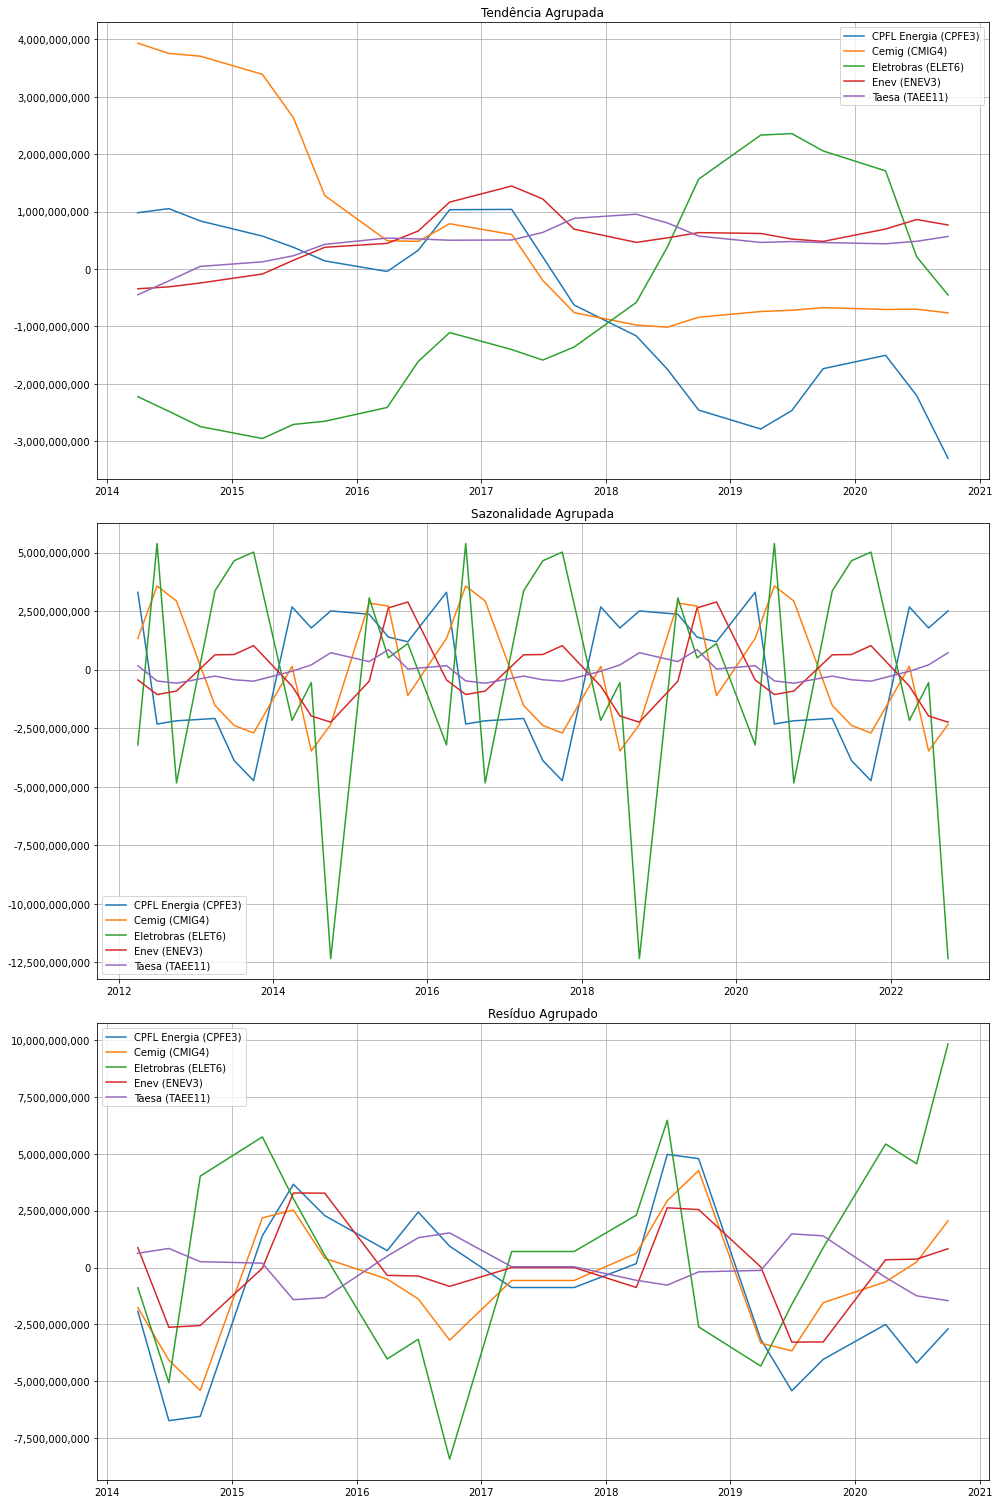

In [49]:
import statsmodels.api as sm
import matplotlib.ticker as ticker

def decompose_series(data, period=12):
    decomposition = sm.tsa.seasonal_decompose(data, period=period)
    return decomposition

def plot_individual_decomposition(data, company_code, period=12):
    company = companies[company_code]
    company_data = data[data['CD_CVM'] == company_code]

    decomposition = decompose_series(company_data['FCFE'], period)

    # Thousand separator
    formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))

    plt.figure(figsize=(14, 7))
    plt.subplot(3, 1, 1)
    plt.plot(decomposition.trend)
    plt.title(f"Tendência - {company['name']} ({company['ticker']})")
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.subplot(3, 1, 2)
    plt.plot(decomposition.seasonal)
    plt.title(f"Sazonalidade - {company['name']} ({company['ticker']})")
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.subplot(3, 1, 3)
    plt.plot(decomposition.resid)
    plt.title(f"Resíduo - {company['name']} ({company['ticker']})")
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.grid(True)
    plt.show()

for company_code in companies:
    plot_individual_decomposition(data, company_code)



def plot_grouped_decomposition(data, companies, period=12):
    plt.figure(figsize=(14, 21))

    # Thousand separator
    formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))

    for company_code in companies:
        company_data = data[data['CD_CVM'] == company_code]
        company = companies[company_code]

        # Serie decomposition
        decomposition = decompose_series(company_data['FCFE'], period)

        # Plotting Tendency
        plt.subplot(3, 1, 1)
        plt.plot(decomposition.trend, label=f"{company['name']} ({company['ticker']})")
        plt.title('Tendência Agrupada')
        plt.legend(loc='best')
        plt.grid(True)
        plt.gca().yaxis.set_major_formatter(formatter)

        # Plotting Tendency Seasonality
        plt.subplot(3, 1, 2)
        plt.plot(decomposition.seasonal, label=f"{company['name']} ({company['ticker']})")
        plt.title('Sazonalidade Agrupada')
        plt.legend(loc='best')
        plt.grid(True)
        plt.gca().yaxis.set_major_formatter(formatter)

        # Plotting Resid
        plt.subplot(3, 1, 3)
        plt.plot(decomposition.resid, label=f"{company['name']} ({company['ticker']})")
        plt.title('Resíduo Agrupado')
        plt.legend(loc='best')
        plt.grid(True)
        plt.gca().yaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_grouped_decomposition(data, companies)

##### Stationarity validation

In [42]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test_and_check(data):
    # Performing the Augmented Dickey-Fuller test:
    result = adfuller(data)

    # Printing results:
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    # Checking the p-value to decide on stationarity:
    if result[1] <= 0.05:
        print("Com 95% de confiança, podemos dizer que a série é estacionária.")
        return True
    else:
        print("Com 95% de confiança, podemos dizer que a série NÃO é estacionária.")
        return False


stationary_series_dict = {}
non_stationary_companies = {}

for company_code in companies:
    company_info = companies[company_code]
    company_data = data[data['CD_CVM'] == company_code]
    print("\n\n------------------------------------------------------")
    print(f"Resultado para a empresa {company_info['name']} ({company_info['ticker']})")
    print("------------------------------------------------------")
    is_stationary = adfuller_test_and_check(company_data['FCFE'])
    if is_stationary:
        stationary_series_dict[company_code] = company_data['FCFE']
    else:
        non_stationary_companies[company_code] = company_data['FCFE']




------------------------------------------------------
Resultado para a empresa CPFL Energia (CPFE3)
------------------------------------------------------
ADF Statistic: 0.5412432691631256
p-value: 0.9860741849658364
Critical Values: {'1%': -3.7377092158564813, '5%': -2.9922162731481485, '10%': -2.635746736111111}
Com 95% de confiança, podemos dizer que a série NÃO é estacionária.


------------------------------------------------------
Resultado para a empresa Cemig (CMIG4)
------------------------------------------------------
ADF Statistic: -4.233132485097103
p-value: 0.0005787874973766701
Critical Values: {'1%': -3.653519805908203, '5%': -2.9572185644531253, '10%': -2.6175881640625}
Com 95% de confiança, podemos dizer que a série é estacionária.


------------------------------------------------------
Resultado para a empresa Eletrobras (ELET6)
------------------------------------------------------
ADF Statistic: -5.89595683792668
p-value: 2.851178763997481e-07
Critical Values: 

##### Non-stationarity transformations


Transformando série para a empresa CPFL Energia (CPFE3)



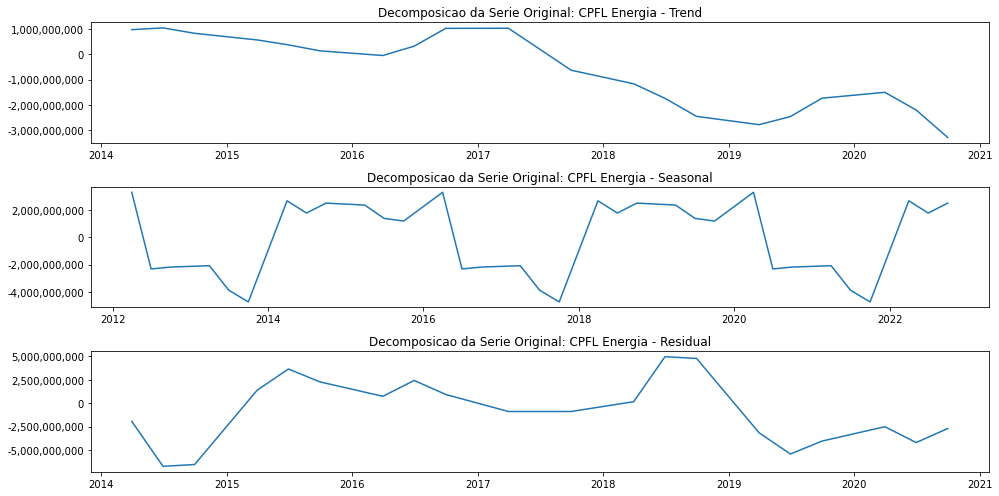

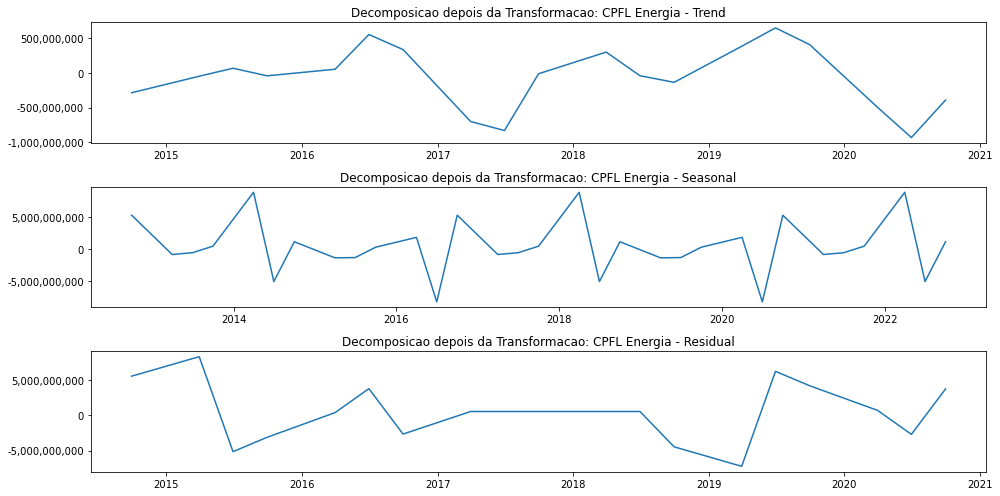

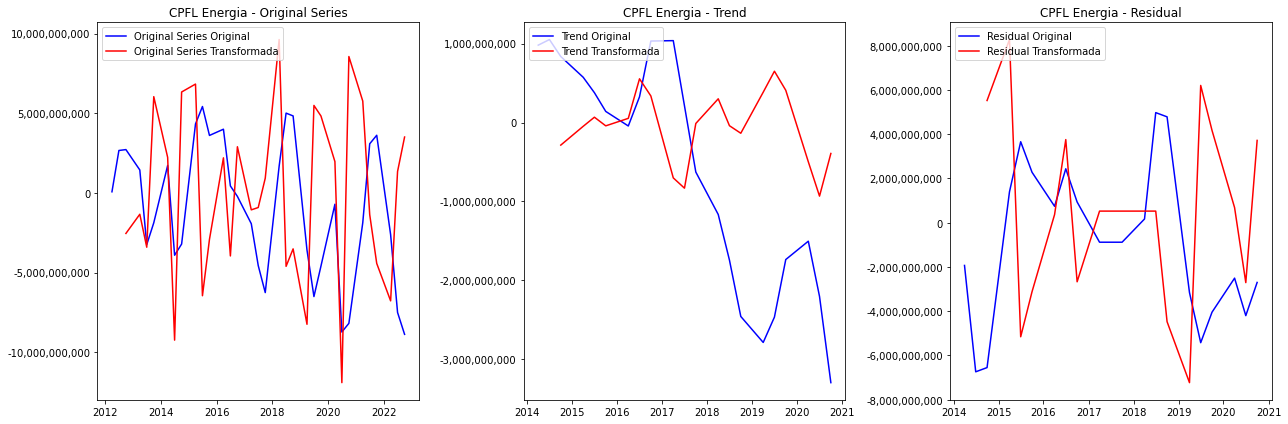

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.ticker as ticker


def adfuller_test(series):
    result = adfuller(series)
    return result[1] <= 0.05  # Retornando diretamente o teste se p <= 0.05


def decompose_series(data, period=12):
    return sm.tsa.seasonal_decompose(data, period=period)


def plot_decomposition(series, title):
    plt.figure(figsize=(14, 7))
    formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))

    decomposition = decompose_series(series)

    components = [('Trend', decomposition.trend), ('Seasonal', decomposition.seasonal), ('Residual', decomposition.resid)]
    for i, (label, component) in enumerate(components, 1):
        plt.subplot(3, 1, i)
        plt.plot(component)
        plt.title(f"{title} - {label}")
        plt.grid(True)
        plt.gca().yaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.show()

def plot_overlaid_decomposition(original_series, transformed_series, title):
    """Plot the overlaid original, trend, and residual decomposition of two time series."""
    orig_decomposition = decompose_series(original_series)
    trans_decomposition = decompose_series(transformed_series)

    plt.figure(figsize=(18, 6))
    formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))

    components = [('Original Series', original_series, transformed_series),
                  ('Trend', orig_decomposition.trend, trans_decomposition.trend),
                  ('Residual', orig_decomposition.resid, trans_decomposition.resid)]

    for i, (label, orig_component, trans_component) in enumerate(components, 1):
        plt.subplot(1, 3, i)
        plt.plot(orig_component.index, orig_component, label=f'{label} Original', color='blue')
        plt.plot(trans_component.index, trans_component, label=f'{label} Transformada', color='red')
        plt.title(f"{title} - {label}")
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.gca().yaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.show()

def make_series_stationary(series, max_diff=2):
    stationary_series = series.copy()
    for _ in range(max_diff):
        stationary_series = stationary_series.diff().dropna()
        if adfuller_test(stationary_series):
            return stationary_series
    return None


def main():
    for company_code, company_series in non_stationary_companies.items():
        company_info = companies[company_code]
        company_data = data[data['CD_CVM'] == company_code]['FCFE']

        print(f"\nTransformando série para a empresa {company_info['name']} ({company_info['ticker']})\n")

        # Plot original series
        plot_decomposition(company_data, title=f"Decomposicao da Serie Original: {company_info['name']}")

        # Making the series stationary
        stationary_series = make_series_stationary(company_data)

        if stationary_series is not None:
            # Plot transformed series
            plot_decomposition(stationary_series, title=f"Decomposicao depois da Transformacao: {company_info['name']}")

            stationary_series_dict[company_code] = stationary_series
            plot_overlaid_decomposition(company_data, stationary_series, company_info['name'])


if __name__ == "__main__":
    main()


#### Prediction using ARIMA

ARIMA (AutoRegressive Integrated Moving Average) é uma classe de modelos que explica uma determinada série temporal com base em seus próprios valores passados, ou seja, seus lags e os erros de previsão atrasados, de modo que a equação pode ser usada para prever valores futuros.

A notação ARIMA(p, d, q) envolve três componentes:

- p é a ordem do componente AR (autoregressivo).
- d é a ordem da diferenciação integrada.
- q é a ordem do componente MA (média móvel).

#### Prediction using SARIMA

SARIMA (Seasonal AutoRegressive Integrated Moving Average) é uma extensão do ARIMA que suporta a modelagem direta da sazonalidade nos dados. Ele adiciona três novos hiperparâmetros para especificar a sazonalidade autoregressiva, diferença e componentes de média móvel.

A notação SARIMA é denotada como ARIMA(p,d,q)(P,D,Q)S.

- P: é a ordem do componente sazonal autoregressivo.
- D: é a ordem da diferenciação sazonal.
- Q: é a ordem do componente sazonal de média móvel.
- S: é o número de períodos em cada temporada (por exemplo, 12 para um ciclo anual em dados mensais).

/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting a

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22547D+01    |proj g|=  9.40379D-01

At iterate    5    f=  1.18354D+01    |proj g|=  3.39705D-02

At iterate   10    f=  1.18200D+01    |proj g|=  5.26295D-03

At iterate   15    f=  1.18179D+01    |proj g|=  1.27600D-03

At iterate   20    f=  1.18177D+01    |proj g|=  3.52739D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   2.299D-05   1.182D+01
  F =   11.817744461000739     

CONVERG

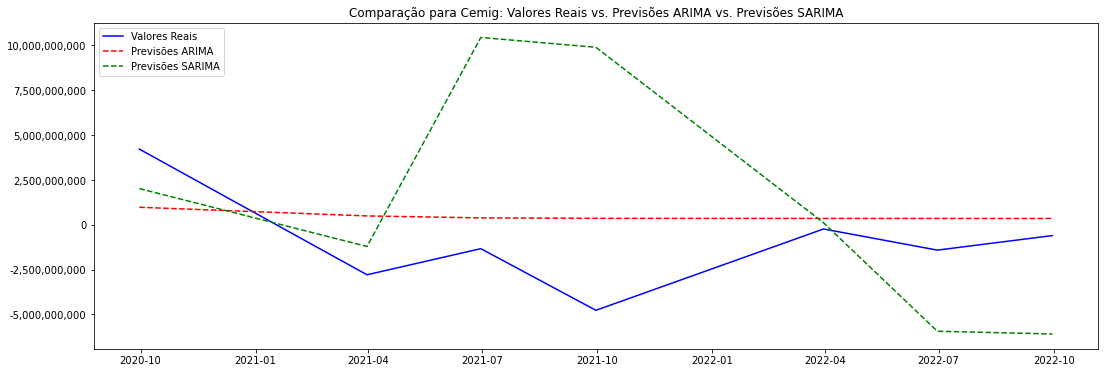

MSE para ARIMA: 7,842,991,815,790,561,280.00
MSE para SARIMA: 58,821,387,612,280,971,264.00
Para a empresa Cemig, o melhor modelo em termos de MSE foi: ARIMA
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21516D+01    |proj g|=  2.32092D-01

At iterate    5    f=  1.20397D+01    |proj g|=  8.35138D-03

At iterate   10    f=  1.20337D+01    |proj g|=  2.77218D-03

At iterate   15    f=  1.20334D+01    |proj g|=  4.21451D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5  

/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_predic

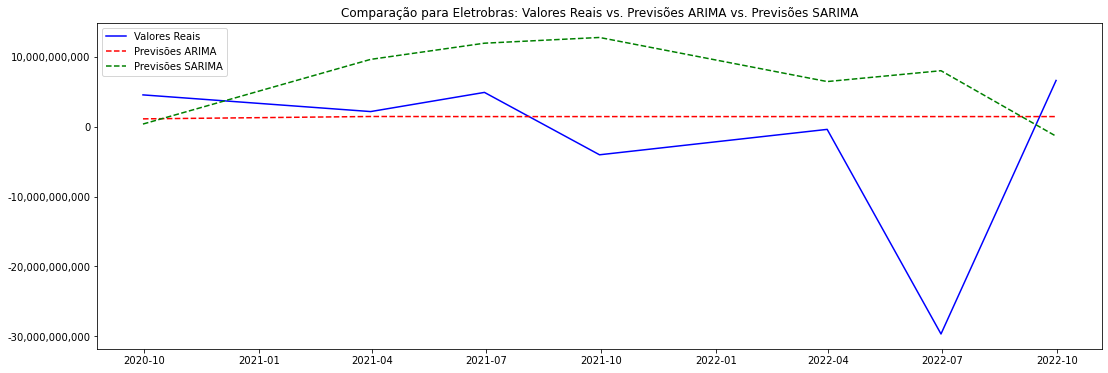

MSE para ARIMA: 150,245,516,108,405,080,064.00
MSE para SARIMA: 276,260,345,786,810,204,160.00
Para a empresa Eletrobras, o melhor modelo em termos de MSE foi: ARIMA
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17251D+01    |proj g|=  2.85328D-01

At iterate    5    f=  1.15740D+01    |proj g|=  1.00831D-02

At iterate   10    f=  1.15657D+01    |proj g|=  1.00882D-03

At iterate   15    f=  1.15644D+01    |proj g|=  2.05522D-03

At iterate   20    f=  1.15641D+01    |proj g|=  3.36409D-04

At iterate   25    f=  1.15641D+01    |proj g|=  7.16032D-05

At iterate   30    f=  1.15641D+01    |proj g|=  9.95861D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bound

/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_predic

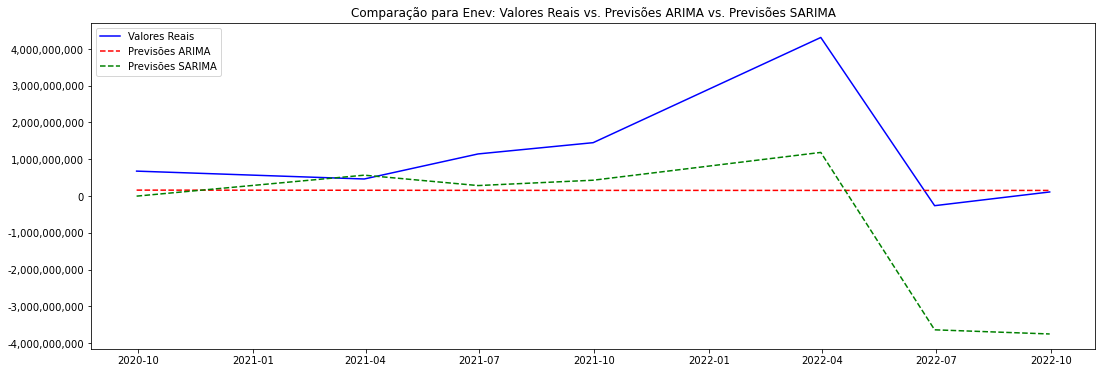

MSE para ARIMA: 2,929,139,975,731,348,992.00
MSE para SARIMA: 5,478,918,199,992,706,048.00
Para a empresa Enev, o melhor modelo em termos de MSE foi: ARIMA
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13953D+01    |proj g|=  3.77752D-01

At iterate    5    f=  1.12156D+01    |proj g|=  2.76669D-02

At iterate   10    f=  1.12013D+01    |proj g|=  5.46522D-03

At iterate   15    f=  1.11922D+01    |proj g|=  2.34789D-04

At iterate   20    f=  1.11922D+01    |proj g|=  6.64748D-04

At iterate   25    f=  1.11921D+01    |proj g|=  1.45103D-04

At iterate   30    f=  1.11920D+01    |proj g|=  1.13588D-04

At iterate   35    f=  1.11920D+01    |proj g|=  1.98547D-05


/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_predic


At iterate   40    f=  1.11920D+01    |proj g|=  1.43758D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     61      1     0     0   1.438D-04   1.119D+01
  F =   11.192038832520561     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


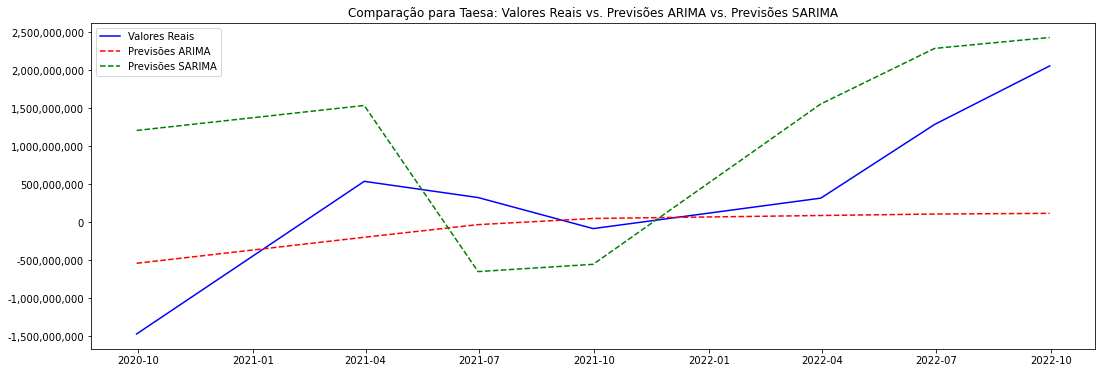

MSE para ARIMA: 964,911,841,310,491,776.00
MSE para SARIMA: 1,716,185,666,973,112,832.00
Para a empresa Taesa, o melhor modelo em termos de MSE foi: ARIMA
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15665D+01    |proj g|=  6.46863D-01

At iterate    5    f=  1.10832D+01    |proj g|=  2.65249D-02

At iterate   10    f=  1.10783D+01    |proj g|=  1.00028D-03

At iterate   15    f=  1.10782D+01    |proj g|=  2.36344D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     

/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters

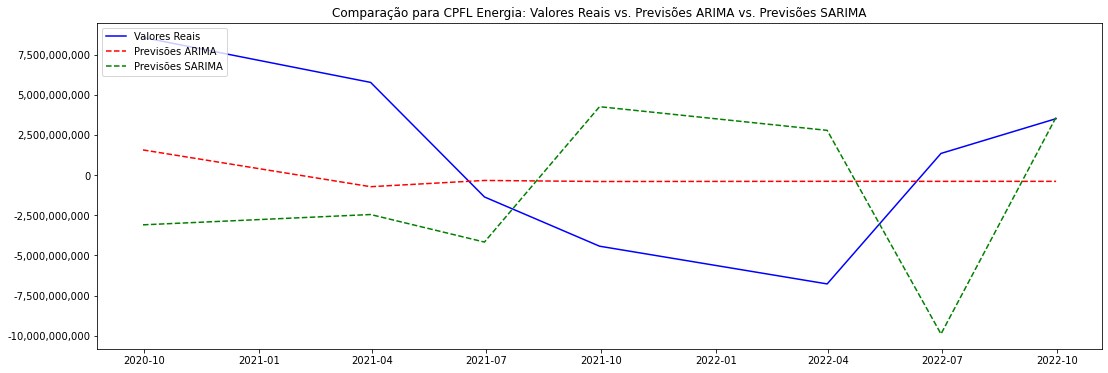

MSE para ARIMA: 23,891,976,762,808,856,576.00
MSE para SARIMA: 72,009,835,315,495,485,440.00
Para a empresa CPFL Energia, o melhor modelo em termos de MSE foi: ARIMA


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def arima_forecast(train_series, test_series, order=(1,1,1)):
    model = ARIMA(train_series, order=order)
    fit_model = model.fit()
    predictions = fit_model.forecast(steps=len(test_series))
    return predictions

def sarima_forecast(train_series, test_series, order=(1,1,1), seasonal_order=(1,1,1,12)):
    model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order)
    fit_model = model.fit()
    predictions = fit_model.forecast(steps=len(test_series))
    return predictions

def plot_forecasts(test_series, arima_preds, sarima_preds, company_name):
    plt.figure(figsize=(18, 6))
    plt.plot(test_series.index, test_series.values, label='Valores Reais', color='blue')
    plt.plot(test_series.index, arima_preds, label='Previsões ARIMA', color='red', linestyle='--')
    plt.plot(test_series.index, sarima_preds, label='Previsões SARIMA', color='green', linestyle='--')
    plt.legend(loc='upper left')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.title(f"Comparação para {company_name}: Valores Reais vs. Previsões ARIMA vs. Previsões SARIMA")
    plt.show()

def evaluate_forecasts(test_series, arima_preds, sarima_preds):
    arima_mse = mean_squared_error(test_series, arima_preds)
    sarima_mse = mean_squared_error(test_series, sarima_preds)

    print(f"MSE para ARIMA: {arima_mse:,.2f}")
    print(f"MSE para SARIMA: {sarima_mse:,.2f}")

    if arima_mse < sarima_mse:
        return "ARIMA"
    elif sarima_mse < arima_mse:
        return "SARIMA"
    else:
        return "Both"

for company_code, series in stationary_series_dict.items():
    # Obter o nome da empresa do dicionário 'companies'
    company_name = companies[company_code]['name']

    # Dividindo os dados em treino e teste
    train_size = int(0.8 * len(series))
    train, test = series[:train_size], series[train_size:]

    arima_predictions = arima_forecast(train, test)
    sarima_predictions = sarima_forecast(train, test)

    # Plot the forecasts with the company name
    plot_forecasts(test, arima_predictions, sarima_predictions, company_name)

    # Evaluate the forecasts
    best_model = evaluate_forecasts(test, arima_predictions, sarima_predictions)
    print(f"Para a empresa {company_name}, o melhor modelo em termos de MSE foi: {best_model}")
